In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.correction import get_pu_weights_function, get_ttbar_weight, get_nlo_weight_function
from FireHydrant.Tools.uproothelpers import fromNestNestIndexArray

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
import os
from os.path import join

########## backgrounds ##########
# bkgdatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_nonempty_v2.json')))
bkgdatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/skimmedbkg_triggerOr.json'))) # skim
bkgscales_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_scale_v2.json')))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        bkgdatasets[tag] = bkgdatasets_[group][tag]

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 59.74*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
# datadatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/Data/Samples/control_data2018_v2.json')))
datadatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/Data/Samples/skimmed_control_data2018_triggerOr.json')))
datadatasets = datadatasets_
datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
datasets.update(datadatasets)

mapping = {}
mapping.update(bkgmapping)
mapping.update(datamapping)
####################################

In [3]:
# using regular expressions on dataset name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!data)')

# common plotting options
fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

In [4]:
ptbinning = np.concatenate([np.arange(0, 300, 10),])
massbinning = np.concatenate([np.arange(0, 20, 1),])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 6, 0, 6)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 24, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 30, -np.pi, np.pi)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 25, 0, np.pi)
        count_axis = hist.Bin('cnt', 'event count', 1, 1, 2)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "leptonjet": hist.Hist("#counts", dataset_axis, pt_axis, mass_axis, eta_axis, phi_axis),
            "ljpair": hist.Hist("#counts", dataset_axis, dphi_axis),
            "eventcnt": hist.Hist("#counts", dataset_axis, count_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            pfiso=df['pfjet_pfIsolation05'],
            ncands=df['pfjet_pfcands_n'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        leptonjets.add_attributes(isoeg=(leptonjets.ismutype | (leptonjets.iseltype&((leptonjets.pfiso<0.1) | (leptonjets.ncands>=2)))))
        leptonjets = leptonjets[leptonjets.isneutral&leptonjets.isoeg]
                
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        leptonjets_ = dileptonjets[isControl]
        if leptonjets_.size==0: return output
        wgt = wgt[isControl]
        lj0 = lj0[isControl]
        lj1 = lj1[isControl]
        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt)
        output['leptonjet'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(),
                                 eta=leptonjets_.eta.flatten(),
                                 phi=leptonjets_.phi.flatten(),
                                 mass=leptonjets_.mass.flatten(),
                                 weight=(leptonjets_.pt.ones_like()*wgt).flatten())
        output['ljpair'].fill(dataset=dataset, dphi=np.abs(lj0.p4.delta_phi(lj1.p4)).flatten(),
                             weight=wgt)
        output['eventcnt'].fill(dataset=dataset, cnt=np.ones_like(wgt), weight=wgt)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 17/17 [00:03<00:00,  5.53items/s]


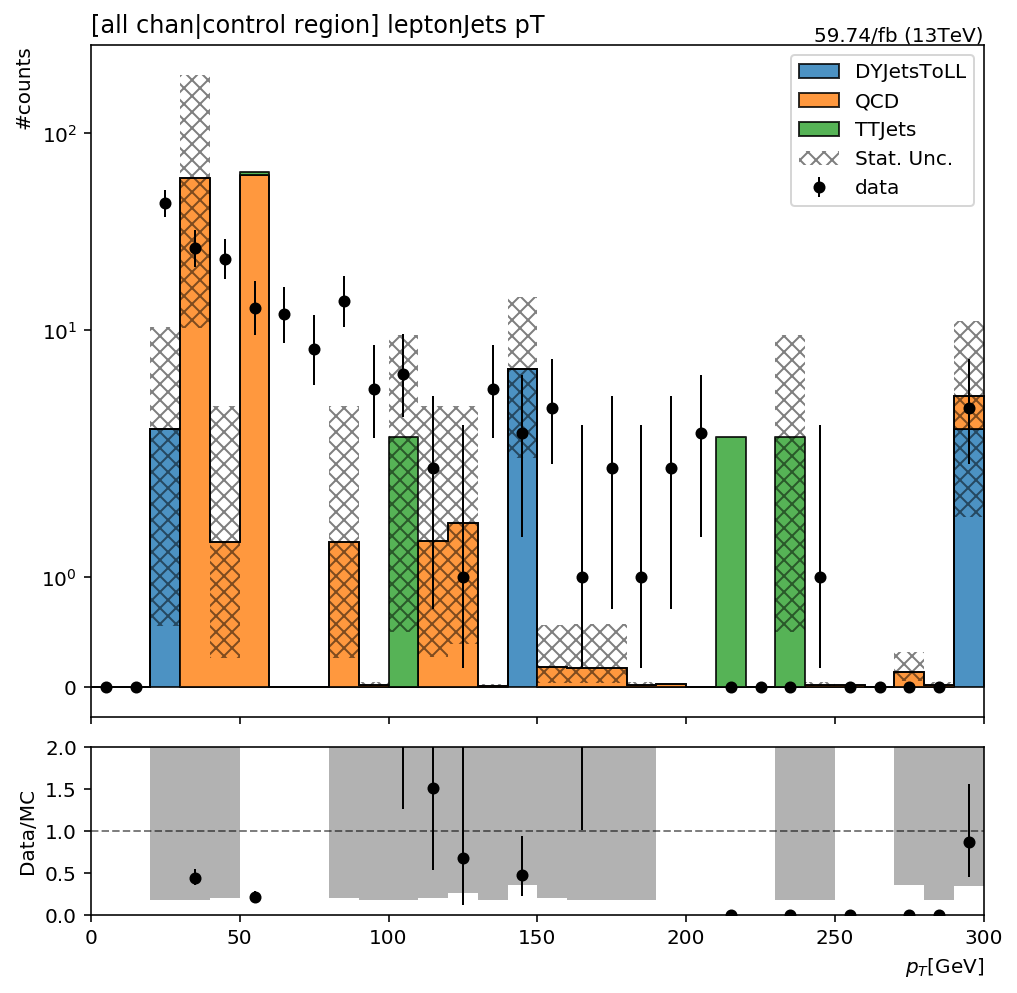

In [6]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['leptonjet_cat'][notdata].sum('eta', 'phi', 'mass', overflow='all'),
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['leptonjet_cat']['data'].sum('eta', 'phi', 'mass', overflow='all'),
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
# ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['leptonjet_cat']['data'].sum('cat', 'eta', 'phi', 'mass', overflow='all'),
               output['leptonjet_cat'][notdata].sum('cat', 'eta', 'phi', 'mass', overflow='all'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Data/MC')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[all chan|control region] leptonJets pT', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

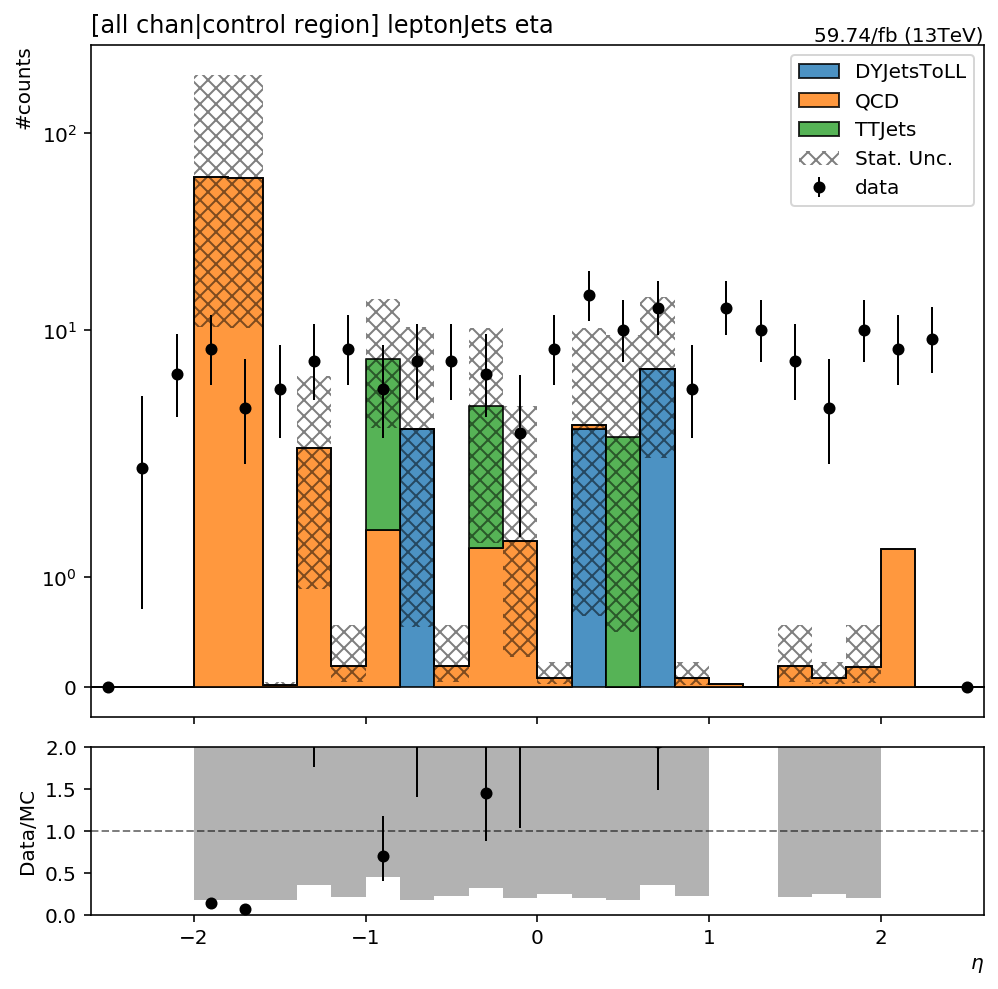

In [7]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['leptonjet_cat'][notdata].sum('pt', 'phi', 'mass', overflow='all'),
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='all',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['leptonjet_cat']['data'].sum('pt', 'phi', 'mass', overflow='all'),
           overlay='cat',
           ax=ax,
           overflow='all',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
# ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['leptonjet_cat']['data'].sum('cat', 'pt', 'phi', 'mass', overflow='all'),
               output['leptonjet_cat'][notdata].sum('cat', 'pt', 'phi', 'mass', overflow='all'),
              ax=rax,
              overflow='all',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Data/MC')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[all chan|control region] leptonJets eta', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

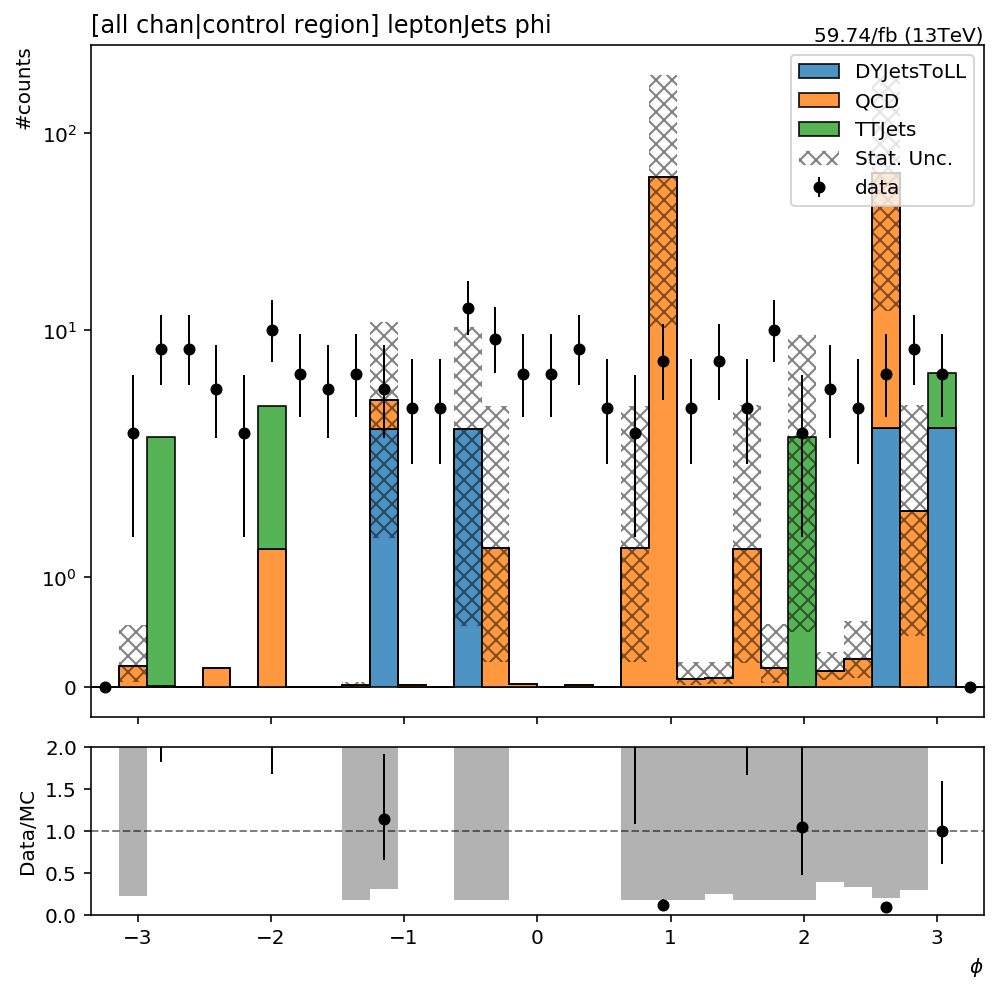

In [8]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['leptonjet_cat'][notdata].sum('pt', 'eta', 'mass', overflow='all'),
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='all',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['leptonjet_cat']['data'].sum('pt', 'eta', 'mass', overflow='all'),
           overlay='cat',
           ax=ax,
           overflow='all',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='x', tight=True)
ax.set_yscale('symlog')
# ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['leptonjet_cat']['data'].sum('cat', 'pt', 'eta', 'mass', overflow='all'),
               output['leptonjet_cat'][notdata].sum('cat', 'pt', 'eta', 'mass', overflow='all'),
              ax=rax,
              overflow='all',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Data/MC')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[all chan|control region] leptonJets phi', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

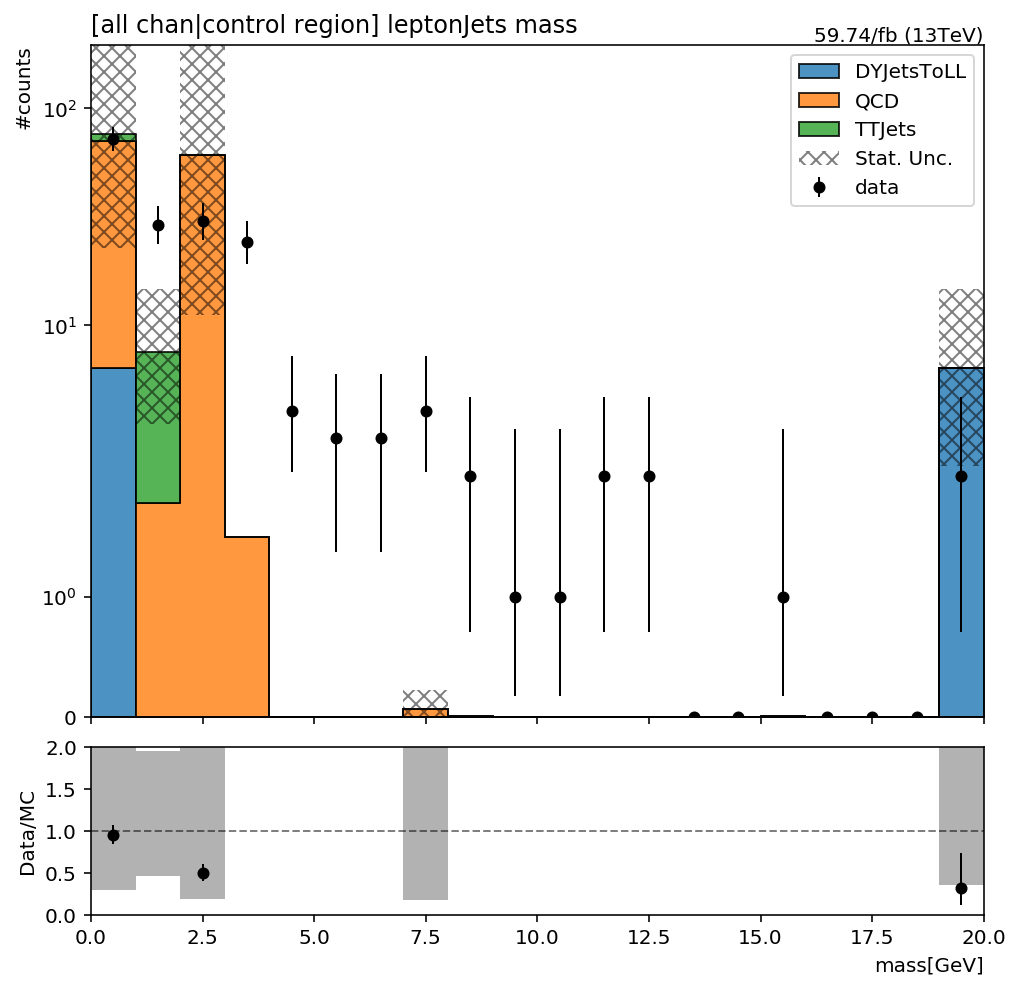

In [9]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['leptonjet_cat'][notdata].sum('pt', 'eta', 'phi', overflow='all'),
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['leptonjet_cat']['data'].sum('pt', 'eta', 'phi', overflow='all'),
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
# ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['leptonjet_cat']['data'].sum('cat', 'pt', 'eta', 'phi', overflow='all'),
               output['leptonjet_cat'][notdata].sum('cat', 'pt', 'eta', 'phi', overflow='all'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Data/MC')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[all chan|control region] leptonJets mass', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

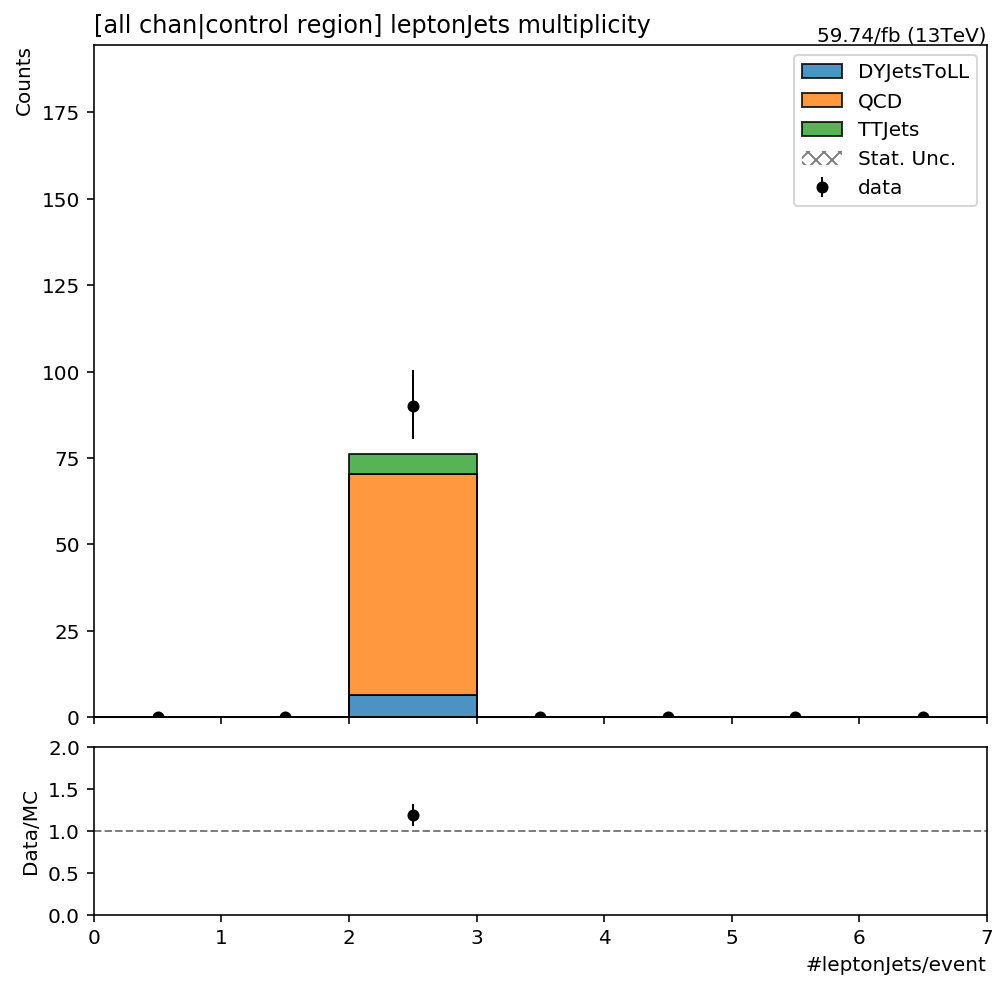

In [10]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['multi_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['multi_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='both', tight=True)
# ax.set_yscale('symlog')
# ax.set_ylim([1, 1e7])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['multi_cat']['data'].sum('cat'),
               output['multi_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Data/MC')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[all chan|control region] leptonJets multiplicity', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

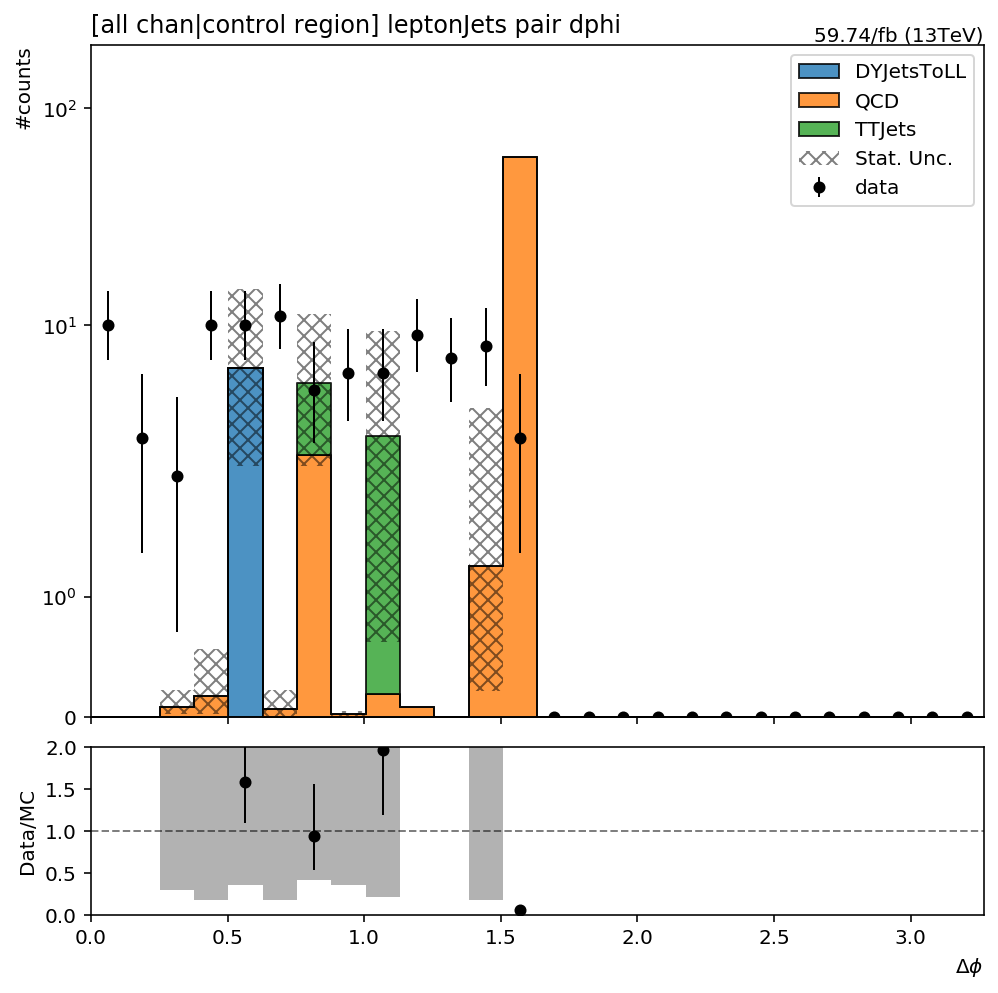

In [11]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['ljpair_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['ljpair_cat']['data'],
           overlay='cat',
           ax=ax,
           overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='both', tight=True)
ax.set_yscale('symlog')
# ax.set_ylim([0, 250])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['ljpair_cat']['data'].sum('cat'),
               output['ljpair_cat'][notdata].sum('cat'),
              ax=rax,
              overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Data/MC')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[all chan|control region] leptonJets pair dphi', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

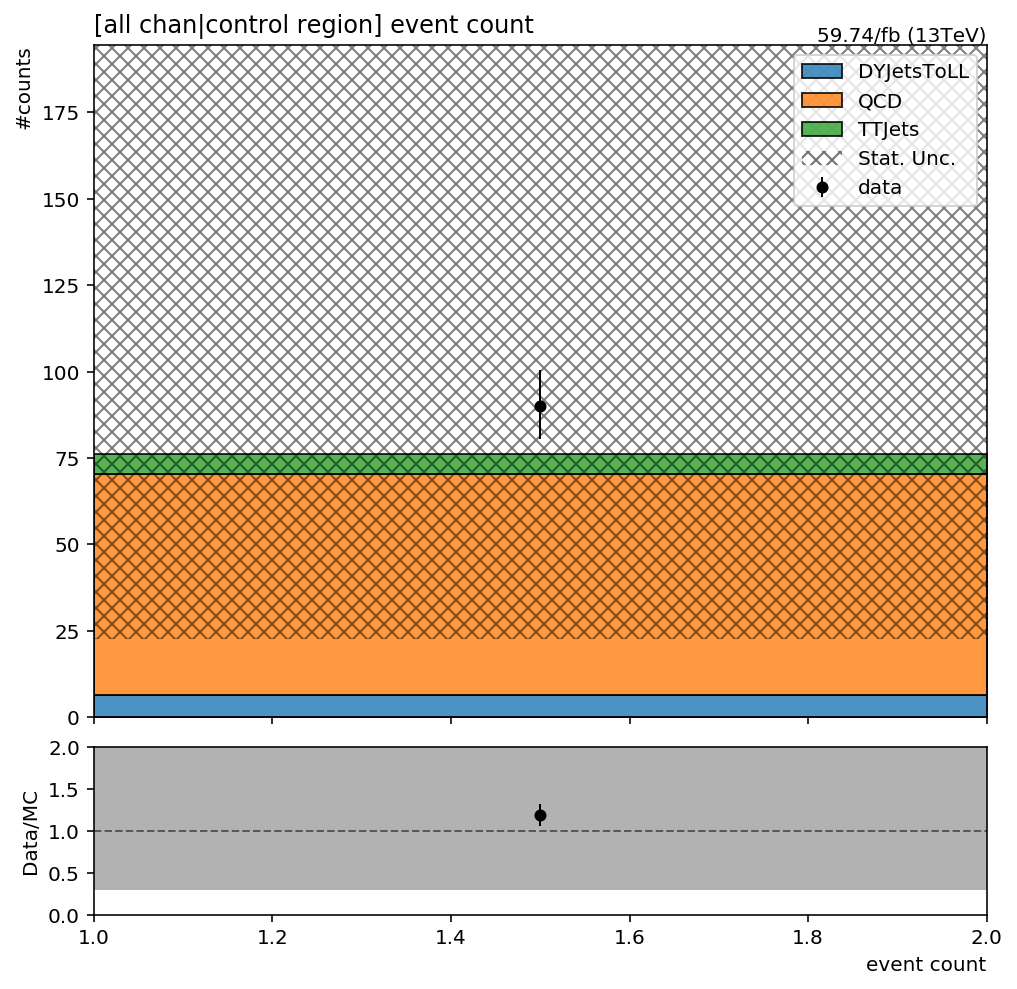

In [12]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={"height_ratios": (4, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

hist.plot1d(output['eventcnt_cat'][notdata],
           overlay='cat',
           ax=ax,
           clear=False,
           stack=True,
           #overflow='over',
           line_opts=None,
           fill_opts=fill_opts,
           error_opts=error_opts)
hist.plot1d(output['eventcnt_cat']['data'],
           overlay='cat',
           ax=ax,
           #overflow='over',
           clear=False,
           error_opts=data_err_opts)
ax.autoscale(axis='both', tight=True)
# ax.set_yscale('symlog')
# ax.set_ylim([0, 250])
ax.set_xlabel(None)
leg=ax.legend()

hist.plotratio(output['eventcnt_cat']['data'].sum('cat'),
               output['eventcnt_cat'][notdata].sum('cat'),
              ax=rax,
              #overflow='over',
              error_opts=data_err_opts,
              denom_fill_opts={},
              guide_opts={},
              unc='num')
rax.set_ylabel('Data/MC')
rax.set_ylim(0,2)

rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
ax.set_title('[all chan|control region] event count', x=0.0, ha="left")
ax.text(1,1,'59.74/fb (13TeV)', ha='right', va='bottom', transform=ax.transAxes);

## split by types

In [13]:
ptbinning = np.concatenate([np.arange(0, 300, 10),])
massbinning = np.concatenate([np.arange(0, 20, 1),])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 6, 0, 6)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 24, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 25, -np.pi, np.pi)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 20, 0, np.pi)
        label_axis = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'ljpt': hist.Hist("#counts", dataset_axis, pt_axis, label_axis),
            'ljeta': hist.Hist("#counts", dataset_axis, eta_axis, label_axis),
            'ljphi': hist.Hist("#counts", dataset_axis, phi_axis, label_axis),
            'ljmass': hist.Hist("#counts", dataset_axis, mass_axis, label_axis),
            "ljpair": hist.Hist("#counts", dataset_axis, dphi_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'].content,
            py=df['pfjet_p4.fCoordinates.fY'].content,
            pz=df['pfjet_p4.fCoordinates.fZ'].content,
            energy=df['pfjet_p4.fCoordinates.fT'].content,
            pfiso=df['pfjet_pfIsolation05'].content,
            ncands=df['pfjet_pfcands_n'].content,
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        leptonjets.add_attributes(isoeg=(leptonjets.ismutype | (leptonjets.iseltype&((leptonjets.pfiso<0.1) | (leptonjets.ncands>=2)))))
        leptonjets = leptonjets[leptonjets.isneutral&leptonjets.isoeg]

#         ljpfmuidx = awkward.fromiter(df['pfjet_pfcand_pfmuonIdx'])
#         haspfmu = (awkward.JaggedArray.fromoffsets(ljpfmuidx.offsets, ljpfmuidx.flatten().counts)>0)
#         ljpfmuSelector = fromNestNestIndexArray(df['muon_selectors'], ljpfmuidx)
#         pfmuloosebit = 1<<15 #np.bitwise_or((1<<3), (1<<24))
#         pfmuloose = (np.bitwise_and(ljpfmuSelector, pfmuloosebit)==pfmuloosebit)
#         pfmulooseall = awkward.JaggedArray.fromoffsets(pfmuloose.offsets, pfmuloose.flatten().all())
#         leptonjets.add_attributes(pfmuLoose=(leptonjets.iseltype | (leptonjets.ismutype&pfmulooseall)))
#         leptonjets = leptonjets[leptonjets.isneutral&(leptonjets.pfmuLoose)]
                
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        leptonjets_ = dileptonjets[isControl]
        if leptonjets_.size==0: return output
        wgt = wgt[isControl]
        lj0 = lj0[isControl]
        lj1 = lj1[isControl]
        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt)
        ljwgt = (leptonjets_.pt.ones_like()*wgt).flatten()
        output['ljpt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt)
        output['ljeta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt)
        output['ljphi'].fill(dataset=dataset, phi=leptonjets_.phi.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt)
        output['ljmass'].fill(dataset=dataset, mass=leptonjets_.mass.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt)

        output['ljpair'].fill(dataset=dataset, dphi=np.abs(lj0.p4.delta_phi(lj1.p4)).flatten(), weight=wgt)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [14]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 17/17 [00:03<00:00,  5.63items/s]


In [15]:
def makeplot(plotvar, title, overflow='over', logy=False):
    fig, (axes, raxes) = plt.subplots(2,3,figsize=(24,8), sharex=True,
                                      gridspec_kw={"height_ratios": (4, 1)},)
    fig.subplots_adjust(hspace=.07, wspace=0.1)

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(1,2)),
               overlay='cat',
               ax=axes[0],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(1,2)),
               overlay='cat',
               ax=axes[0],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(1,2)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(1,2)).sum('cat'),
                   ax=raxes[0],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(2,3)),
               overlay='cat',
               ax=axes[1],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(2,3)),
               overlay='cat',
               ax=axes[1],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(2,3)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(2,3)).sum('cat'),
                   ax=raxes[1],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(3,4)),
               overlay='cat',
               ax=axes[2],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(3,4)),
               overlay='cat',
               ax=axes[2],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(3,4)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(3,4)).sum('cat'),
                   ax=raxes[2],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')
    for ax in axes:
        ax.autoscale(axis='both', tight=True)
        if logy:
            ax.set_yscale('symlog')
        ax.set_xlabel(None)
        leg=ax.legend()
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        ax.text(1,1,'59.74/fb (13TeV)',
                ha='right', va='bottom', transform=ax.transAxes)

    for rax in raxes:
        rax.set_ylabel('Data/MC')
        rax.set_ylim(0,2)
        rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")


    axes[0].set_title(f'[control region] egamma-type leptonjets {title}', x=0.0, ha="left")
    axes[1].set_title(f'[control region] pfmu-type leptonjets {title}', x=0.0, ha="left")
    axes[2].set_title(f'[control region] dsamu-type leptonjets {title}', x=0.0, ha="left")

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


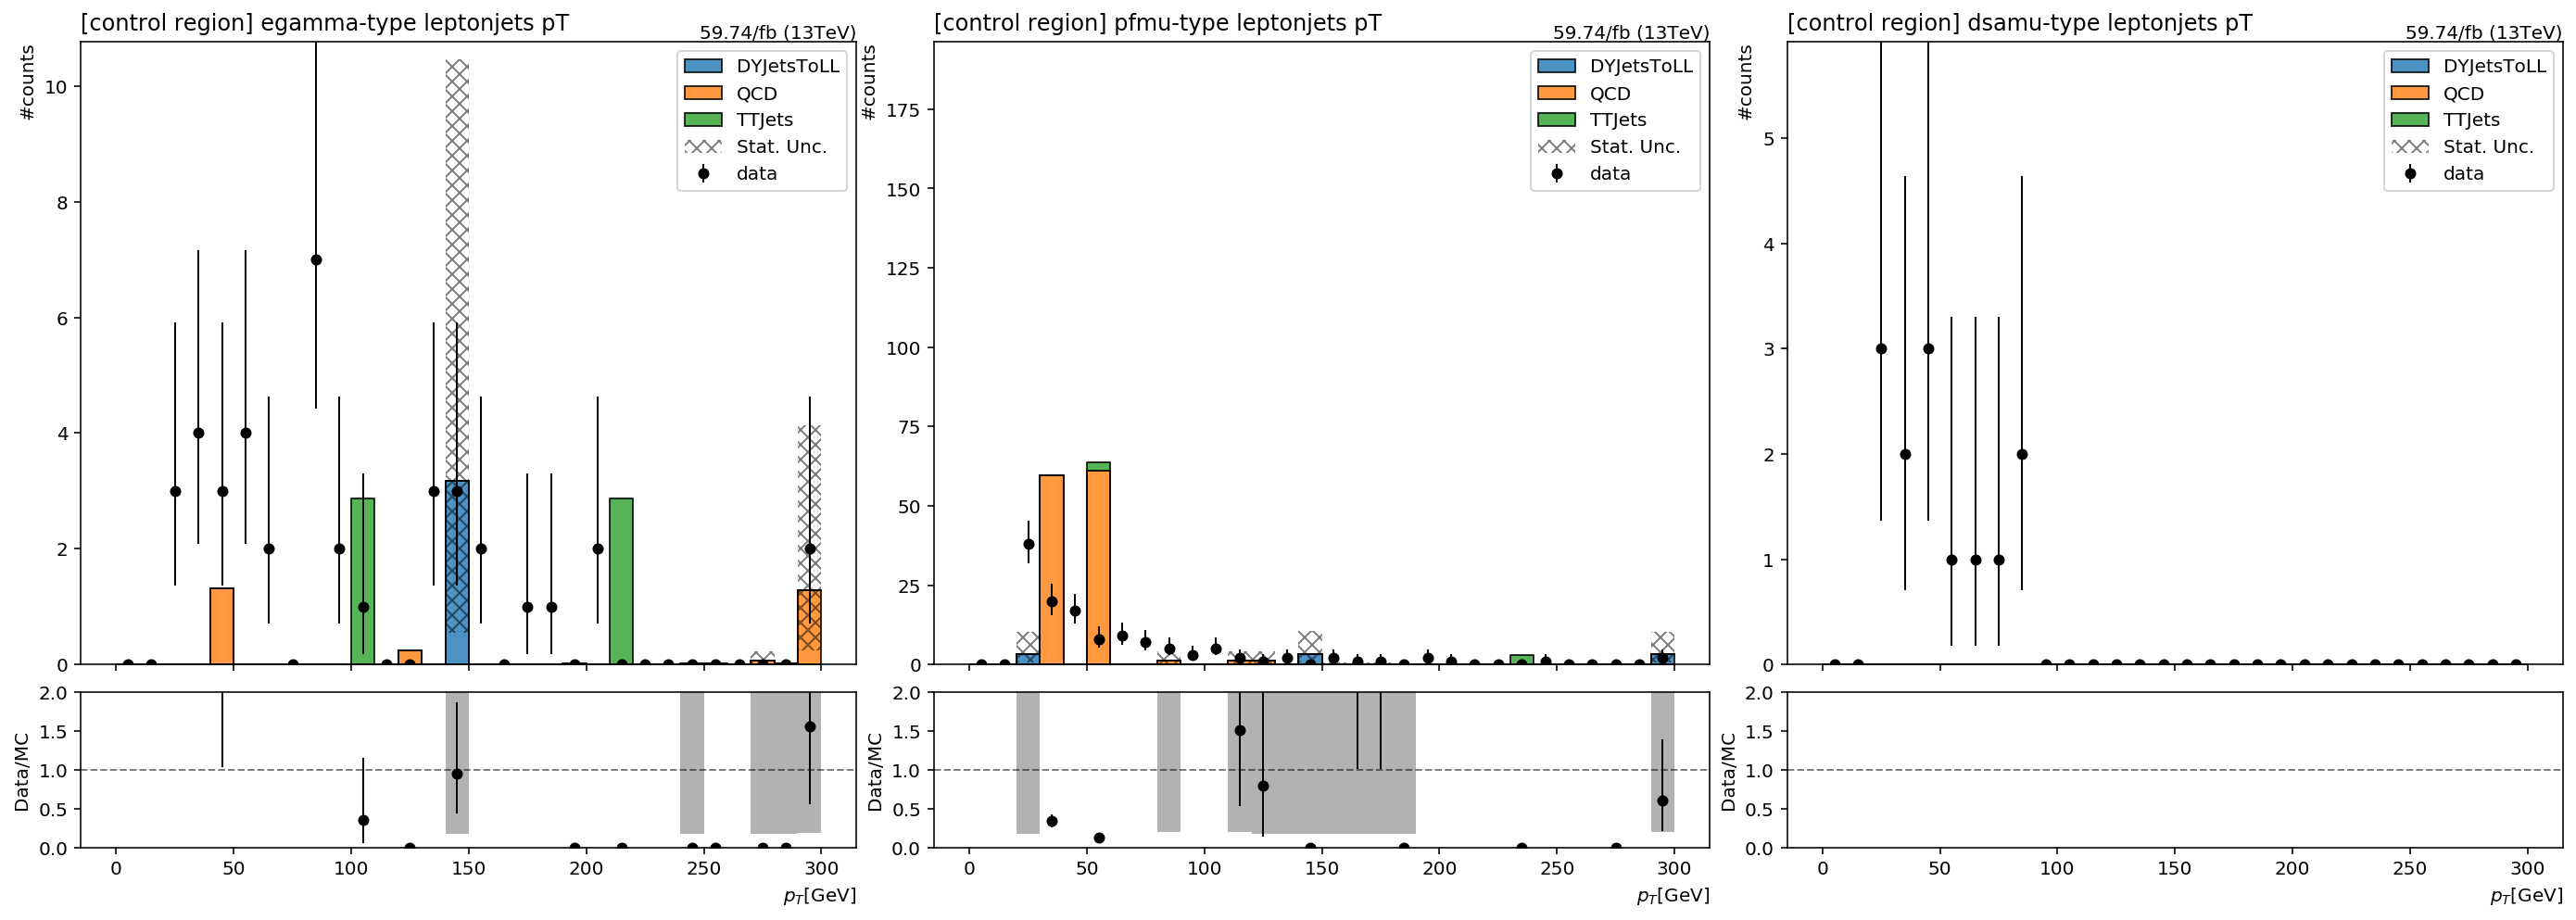

In [16]:
makeplot('ljpt_cat', 'pT')

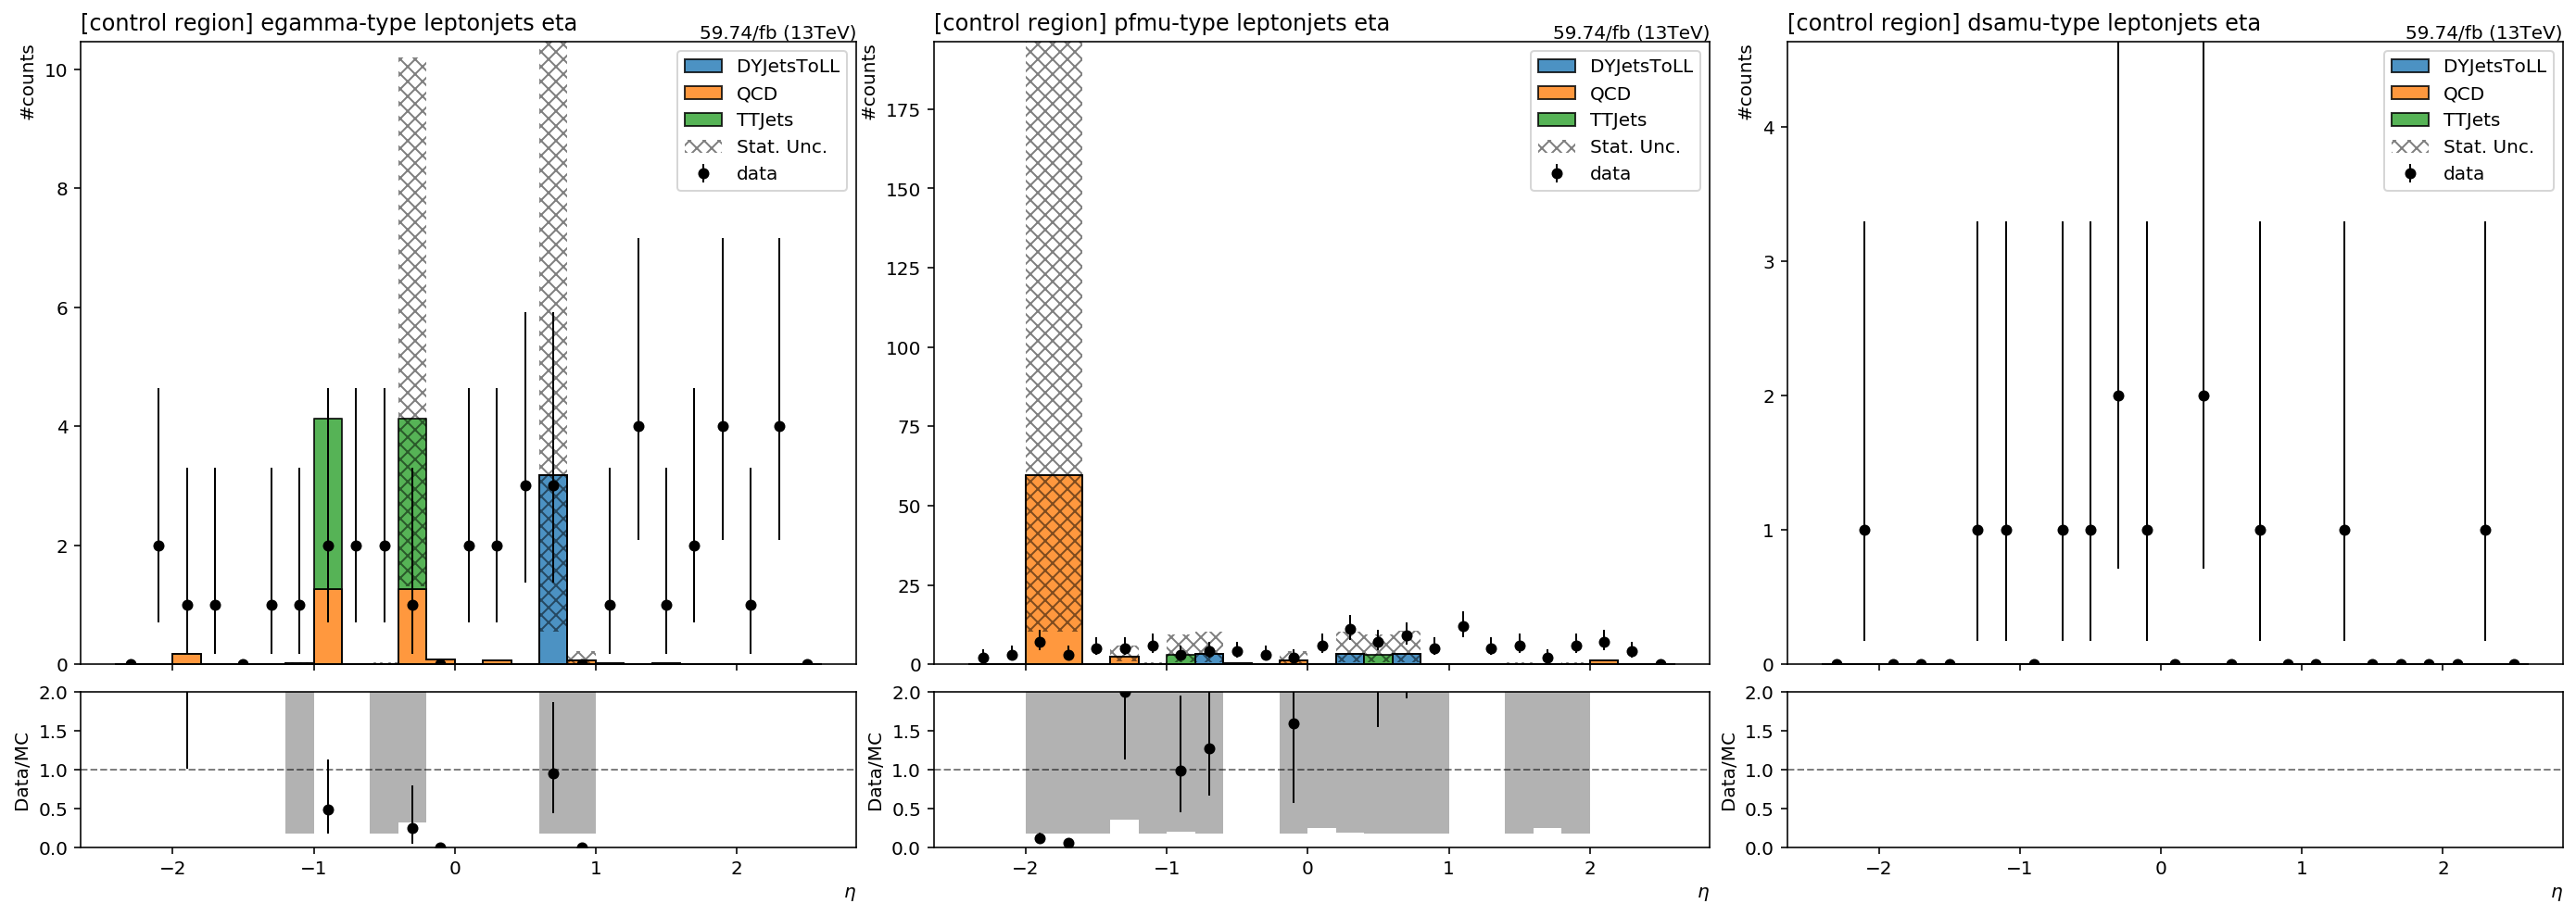

In [17]:
makeplot('ljeta_cat', 'eta')

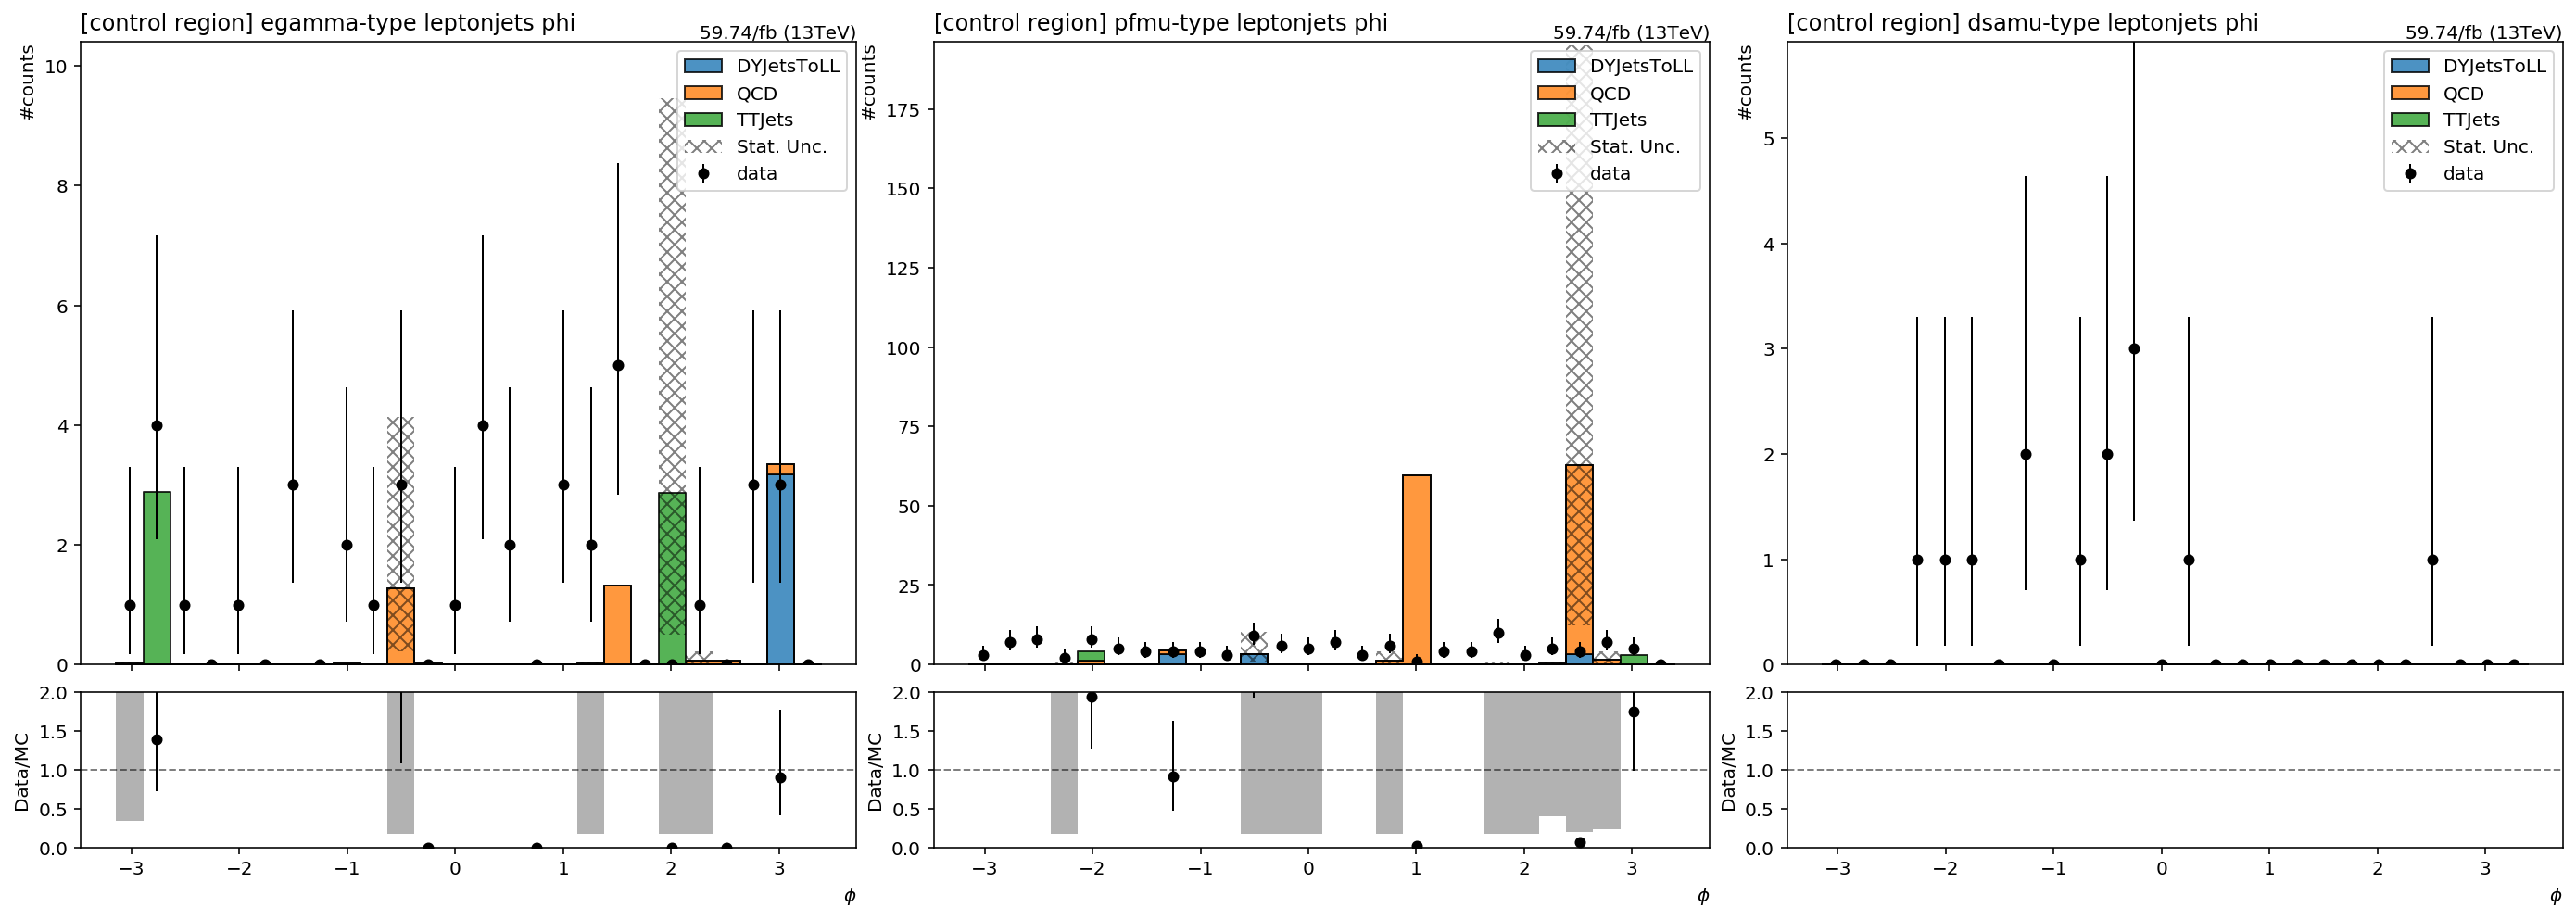

In [18]:
makeplot('ljphi_cat', 'phi')

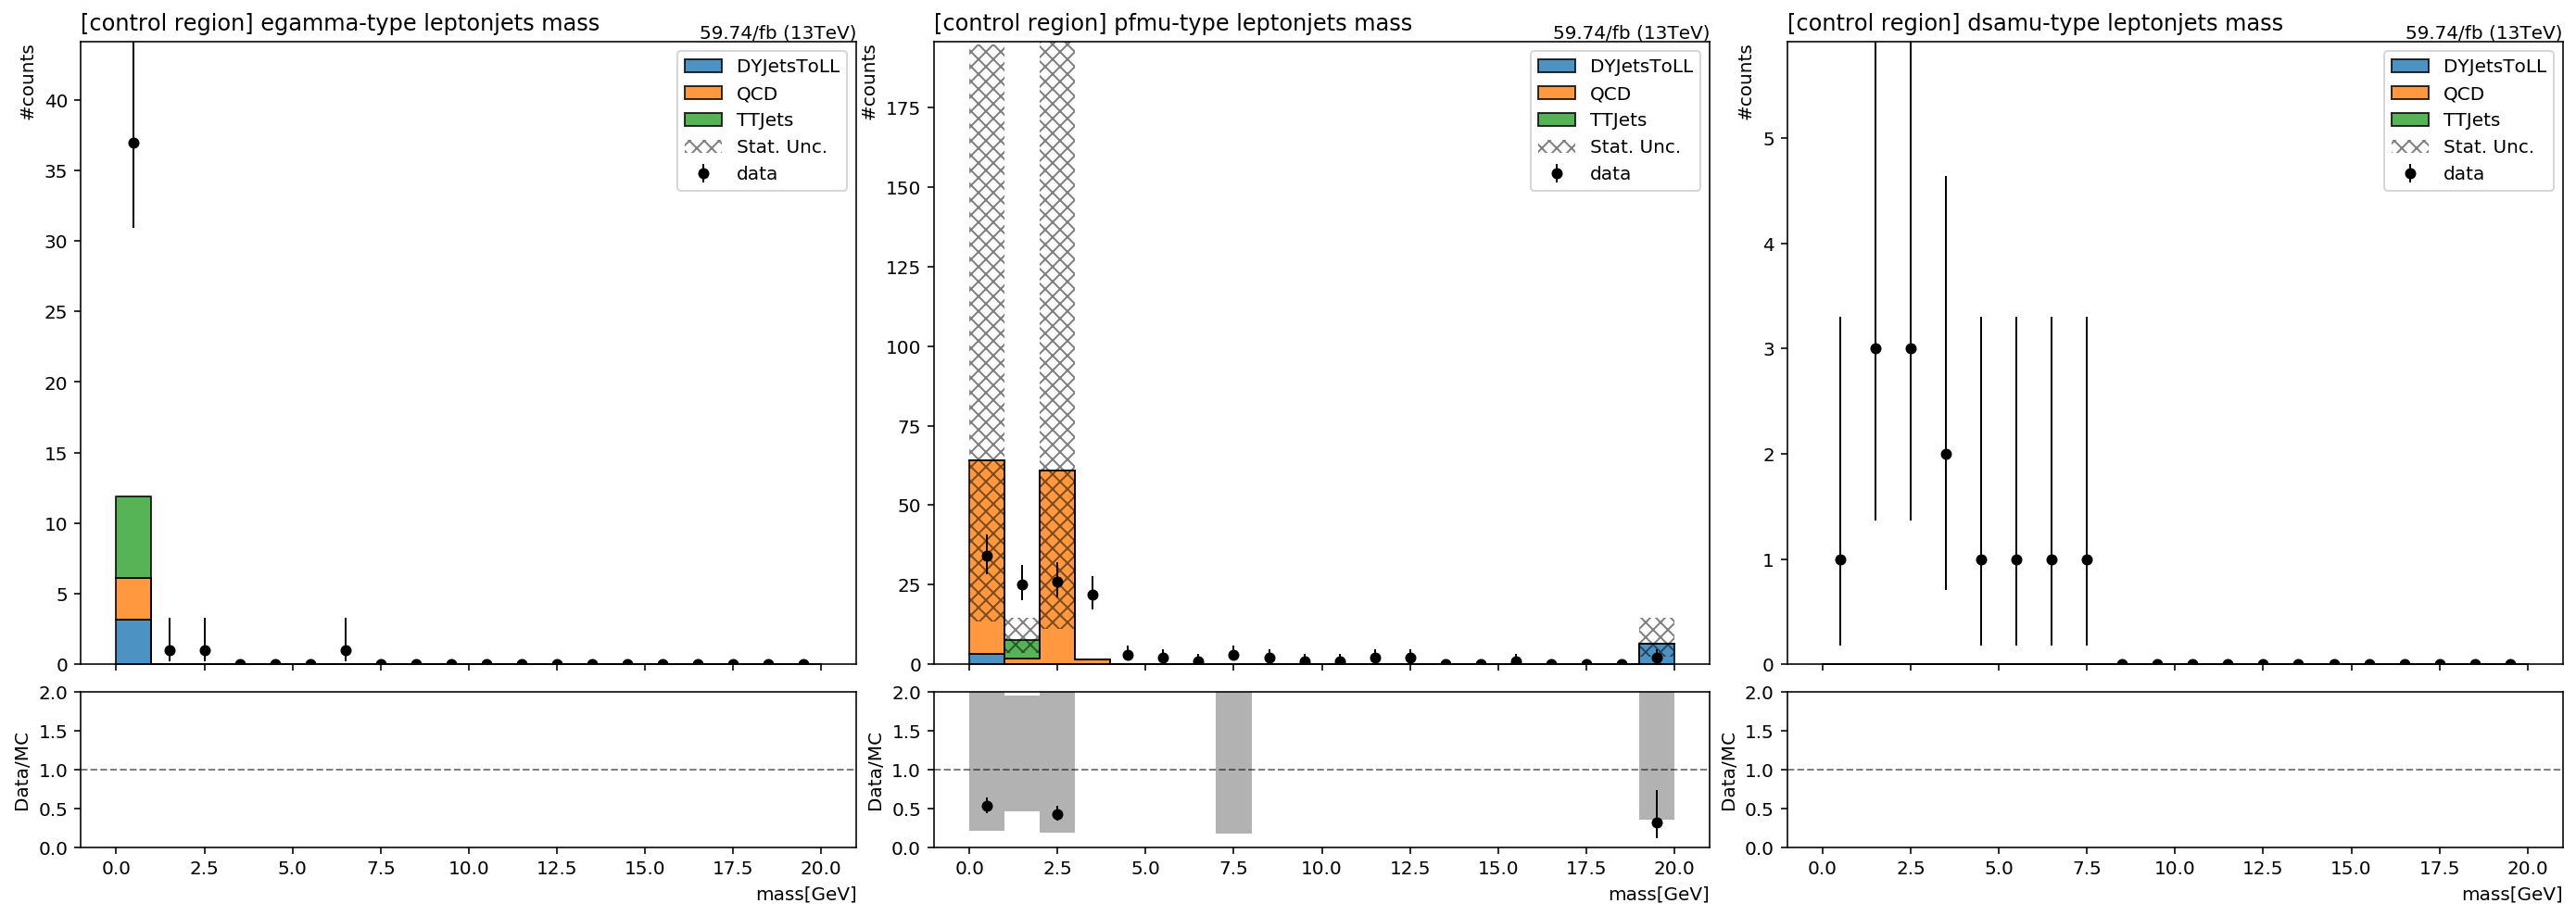

In [19]:
makeplot('ljmass_cat', 'mass')

## split by channels

In [4]:
ptbinning = np.concatenate([np.arange(0, 300, 10),])
massbinning = np.concatenate([np.arange(0, 20, 1),])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 6, 0, 6)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 24, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 30, -np.pi, np.pi)
        qsum_axis = hist.Bin('qsum', '$\Sigma q$', 5, -2, 3)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 30, 0, np.pi)
        label_axis = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        count_axis = hist.Bin('cnt', 'event count', 1, 1, 2)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'ljpt': hist.Hist("#counts", dataset_axis, pt_axis, label_axis, channel_axis),
            'ljeta': hist.Hist("#counts", dataset_axis, eta_axis, label_axis, channel_axis),
            'ljphi': hist.Hist("#counts", dataset_axis, phi_axis, label_axis, channel_axis),
            'ljmass': hist.Hist("#counts", dataset_axis, mass_axis, label_axis, channel_axis),
            'ljqsum': hist.Hist("#counts", dataset_axis, qsum_axis, label_axis, channel_axis),
            "ljpair": hist.Hist("#counts", dataset_axis, dphi_axis, channel_axis),
            'eventcnt': hist.Hist("Counts", dataset_axis, count_axis, channel_axis),
            'ljcnt': hist.Hist("Counts", dataset_axis, count_axis, label_axis, channel_axis),
            
            'run_1': processor.column_accumulator(np.zeros(shape=(0,))),
            'lumi_1': processor.column_accumulator(np.zeros(shape=(0,))),
            'event_1': processor.column_accumulator(np.zeros(shape=(0,))),
            'run_2': processor.column_accumulator(np.zeros(shape=(0,))),
            'lumi_2': processor.column_accumulator(np.zeros(shape=(0,))),
            'event_2': processor.column_accumulator(np.zeros(shape=(0,))),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']
        run = df['run']
        lumi = df['lumi']
        event = df['event']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        primaryvtxmask = df['metfilters_PrimaryVertexFilter']
        wgts.add('primaryvtx', primaryvtxmask)
        
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            pfiso=df['pfjet_pfIsolation06'], # pfiso06
            ncands=df['pfjet_pfcands_n']
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        leptonjets.add_attributes(isoeg=(leptonjets.ismutype | (leptonjets.iseltype&((leptonjets.pfiso<0.1) | (leptonjets.ncands>=2)))))
        leptonjets = leptonjets[leptonjets.isneutral&leptonjets.isoeg]
                
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        run = run[twoleptonjets]
        lumi = lumi[twoleptonjets]
        event = event[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        output['run_1'] += processor.column_accumulator(run[channel_==1])
        output['lumi_1'] += processor.column_accumulator(lumi[channel_==1])
        output['event_1'] += processor.column_accumulator(event[channel_==1])
        output['run_2'] += processor.column_accumulator(run[channel_==2])
        output['lumi_2'] += processor.column_accumulator(lumi[channel_==2])
        output['event_2'] += processor.column_accumulator(event[channel_==2])
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        leptonjets_ = dileptonjets[isControl]
        if leptonjets_.size==0: return output
        wgt = wgt[isControl]
        lj0 = lj0[isControl]
        lj1 = lj1[isControl]
        channel_ = channel_[isControl]
        
#         if dataset.startswith('QCD') and wgt[channel_==2].size>0:
#             run = df['run'][twoleptonjets][isControl&(channel_==2)]
#             lumi = df['lumi'][twoleptonjets][isControl&(channel_==2)]
#             event = df['event'][twoleptonjets][isControl&(channel_==2)]
#             for r, l, e in np.nditer([run, lumi, event]):
#                 print(f'{dataset} | {r}:{l}:{e} -- weight: {wgt}')
#             if dataset=='QCD_Pt-120to170':
#                 print(f'weight: {wgt}')
            
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt, channel=channel_)
        output['eventcnt'].fill(dataset=dataset, cnt=np.ones_like(wgt), weight=wgt, channel=channel_)
        ljwgt = (leptonjets_.pt.ones_like()*wgt).flatten()
        ljchannel = (leptonjets_.pt.ones_like()*channel_).flatten()
        output['ljpt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljeta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljphi'].fill(dataset=dataset, phi=leptonjets_.phi.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljmass'].fill(dataset=dataset, mass=leptonjets_.mass.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljqsum'].fill(dataset=dataset, qsum=leptonjets_.qsum.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljcnt'].fill(dataset=dataset, cnt=np.ones_like(ljwgt), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        
        output['ljpair'].fill(dataset=dataset, dphi=np.abs(lj0.p4.delta_phi(lj1.p4)).flatten(), weight=wgt, channel=channel_)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            if isinstance(accumulator[k], hist.Hist):
                accumulator[k].scale(bkgscales, axis='dataset')
                accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                             hist.Cat("cat", "datasets"),
                                                             mapping)
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 17/17 [00:03<00:00,  5.62items/s]


In [6]:
def makeplot_2mu2e(plotvar, title, overflow='over', logy=True):
    fig, (axes, raxes) = plt.subplots(2,3,figsize=(24,8), sharex=True,
                                      gridspec_kw={"height_ratios": (4, 1)},)
    fig.subplots_adjust(hspace=.07, wspace=0.1)

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(1,2)).integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[0],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(1,2)).integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[0],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(1,2)).integrate('channel', slice(1,2)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(1,2)).integrate('channel', slice(1,2)).sum('cat'),
                   ax=raxes[0],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(2,3)).integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[1],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(2,3)).integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[1],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(2,3)).integrate('channel', slice(1,2)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(2,3)).integrate('channel', slice(1,2)).sum('cat'),
                   ax=raxes[1],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(3,4)).integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[2],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(3,4)).integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[2],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(3,4)).integrate('channel', slice(1,2)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(3,4)).integrate('channel', slice(1,2)).sum('cat'),
                   ax=raxes[2],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')
    for ax in axes:
        ax.autoscale(axis='both', tight=True)
        if logy:
            ax.set_yscale('symlog')
        ax.set_xlabel(None)
        leg=ax.legend()
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        ax.text(1,1,'59.74/fb (13TeV)',
                ha='right', va='bottom', transform=ax.transAxes)

    for rax in raxes:
        rax.set_ylabel('Data/MC')
        rax.set_ylim(0,2)
        rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")


    axes[0].set_title(f'[2mu2e|control region] egamma-type leptonjets {title}', x=0.0, ha="left")
    axes[1].set_title(f'[2mu2e|control region] pfmu-type leptonjets {title}', x=0.0, ha="left")
    axes[2].set_title(f'[2mu2e|control region] dsamu-type leptonjets {title}', x=0.0, ha="left")

def makeplot_4mu(plotvar, title, overflow='over', logy=True, xlim=None):
    fig, (axes, raxes) = plt.subplots(2,3,figsize=(24,8), sharex=True,
                                      gridspec_kw={"height_ratios": (4, 1)},)
    fig.subplots_adjust(hspace=.07, wspace=0.1)

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(1,2)).integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[0],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(1,2)).integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[0],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(1,2)).integrate('channel', slice(2,3)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(1,2)).integrate('channel', slice(2,3)).sum('cat'),
                   ax=raxes[0],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(2,3)).integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[1],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(2,3)).integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[1],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(2,3)).integrate('channel', slice(2,3)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(2,3)).integrate('channel', slice(2,3)).sum('cat'),
                   ax=raxes[1],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('label', slice(3,4)).integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[2],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('label', slice(3,4)).integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[2],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('label', slice(3,4)).integrate('channel', slice(2,3)).sum('cat'),
                   output[plotvar][notdata].integrate('label', slice(3,4)).integrate('channel', slice(2,3)).sum('cat'),
                   ax=raxes[2],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')
    for ax in axes:
        ax.autoscale(axis='both', tight=True)
        if logy:
            ax.set_yscale('symlog')
        ax.set_xlabel(None)
        leg=ax.legend()
        if xlim:
            ax.set_xlim(*xlim)
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        ax.text(1,1,'59.74/fb (13TeV)',
                ha='right', va='bottom', transform=ax.transAxes)

    for rax in raxes:
        rax.set_ylabel('Data/MC')
        rax.set_ylim(0,2)
        rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")


    axes[0].set_title(f'[4mu|control region] egamma-type leptonjets {title}', x=0.0, ha="left")
    axes[1].set_title(f'[4mu|control region] pfmu-type leptonjets {title}', x=0.0, ha="left")
    axes[2].set_title(f'[4mu|control region] dsamu-type leptonjets {title}', x=0.0, ha="left")

    
#######################
from collections import defaultdict
import pandas as pd

def printYield_2mu2e():
    # 2mu2e channel
    result = defaultdict(dict)
    for i, name in enumerate(['egamma', 'pfmu', 'dsamu'], start=1):
        histMC = output['ljcnt_cat'][notdata].integrate('label', slice(i,i+1)).integrate('channel', slice(1,2))
        histData = output['ljcnt_cat']['data'].integrate('label', slice(i,i+1)).integrate('channel', slice(1,2))
        for k, v in histMC.values().items():
            result[name][k[0]] = round(v[0], 2)
        for k, v in histData.values().items():
            result[name][k[0]] = round(v[0], 2)
    return pd.DataFrame(result)

def printYield_4mu():
    # 4mu channel
    result = defaultdict(dict)
    for i, name in enumerate(['egamma', 'pfmu', 'dsamu'], start=1):
        histMC = output['ljcnt_cat'][notdata].integrate('label', slice(i,i+1)).integrate('channel', slice(2,3))
        histData = output['ljcnt_cat']['data'].integrate('label', slice(i,i+1)).integrate('channel', slice(2,3))
        for k, v in histMC.values().items():
            result[name][k[0]] = round(v[0], 2)
        for k, v in histData.values().items():
            result[name][k[0]] = round(v[0], 2)
    return pd.DataFrame(result)

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


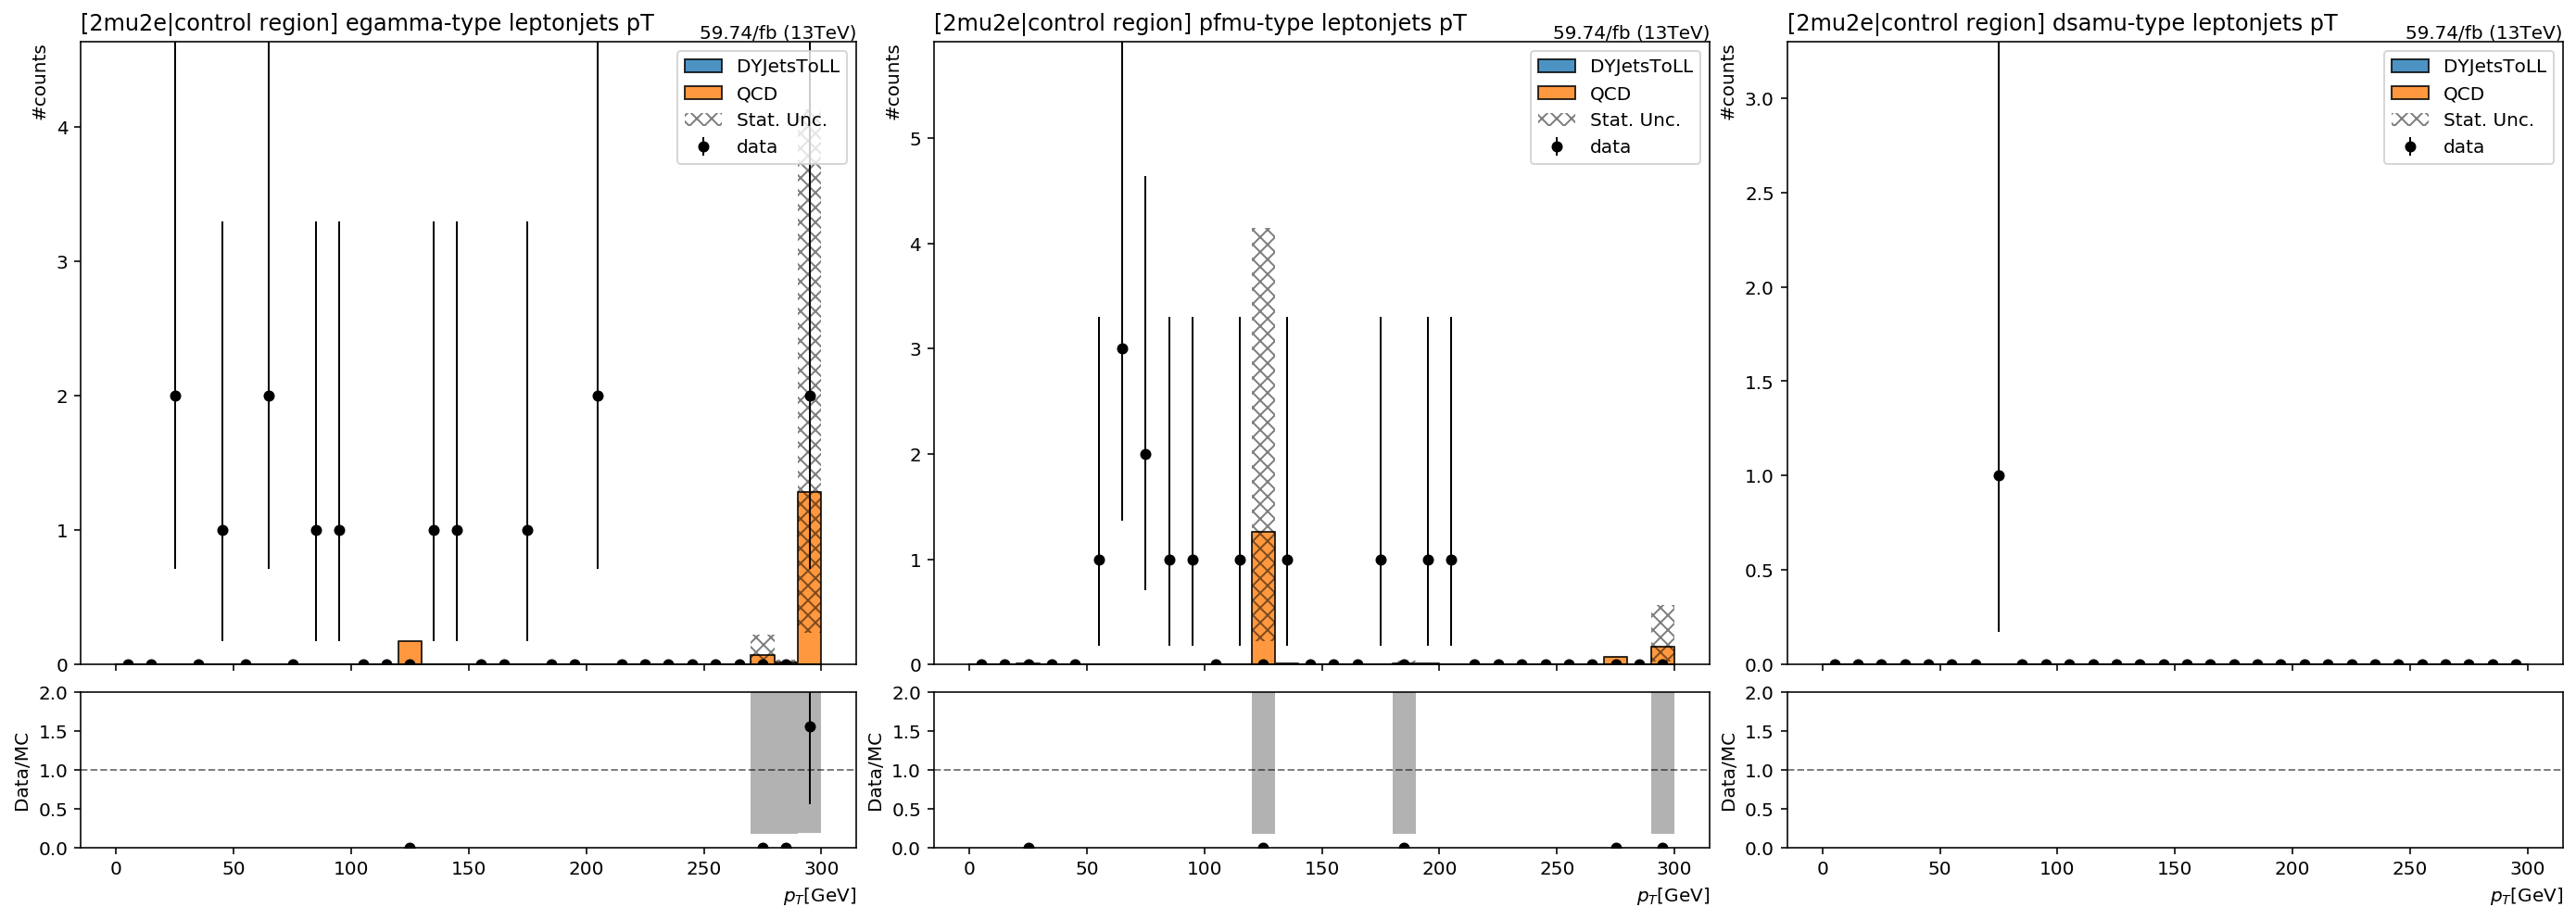

In [7]:
makeplot_2mu2e('ljpt_cat', 'pT', logy=False)

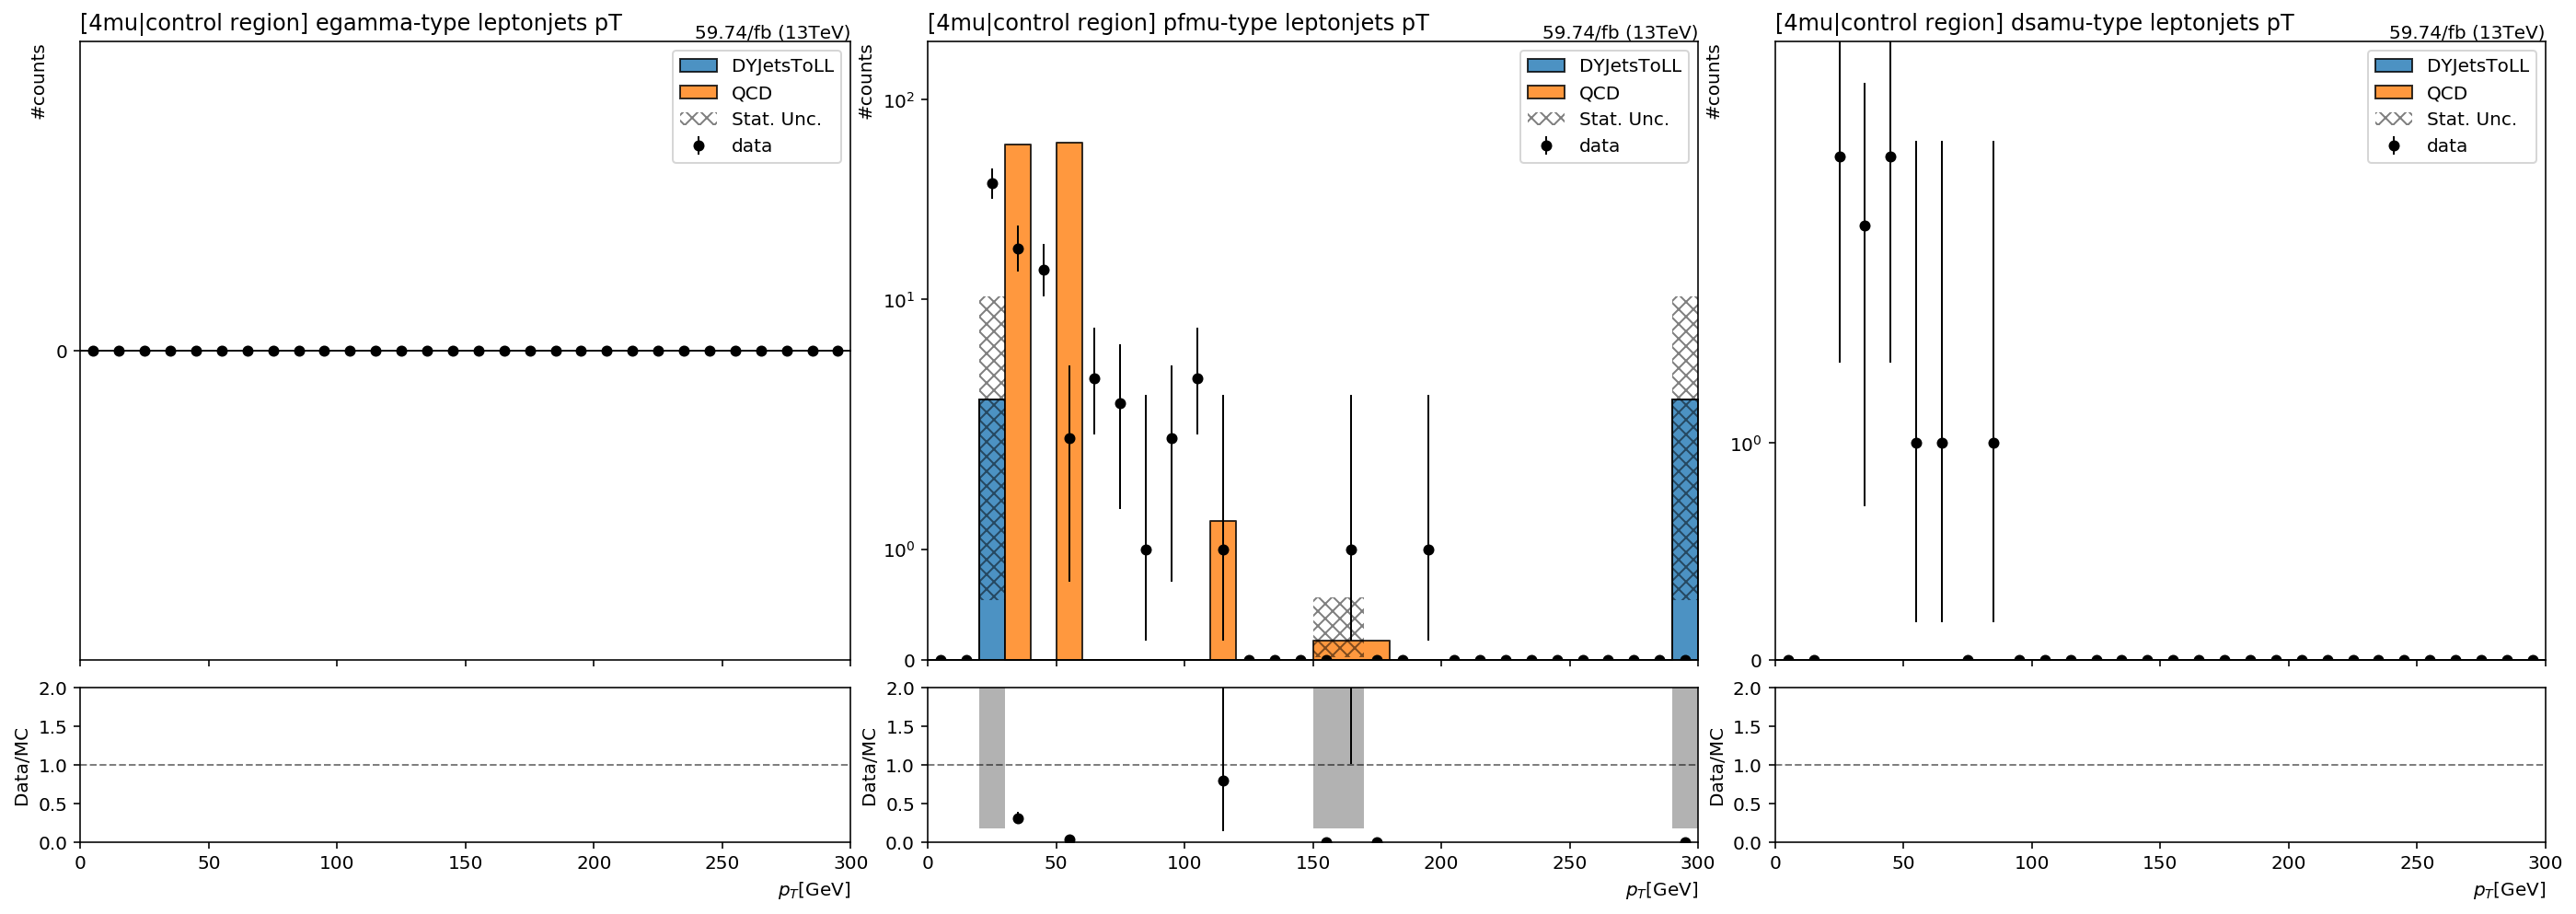

In [8]:
makeplot_4mu('ljpt_cat', 'pT', xlim=[0, 300])

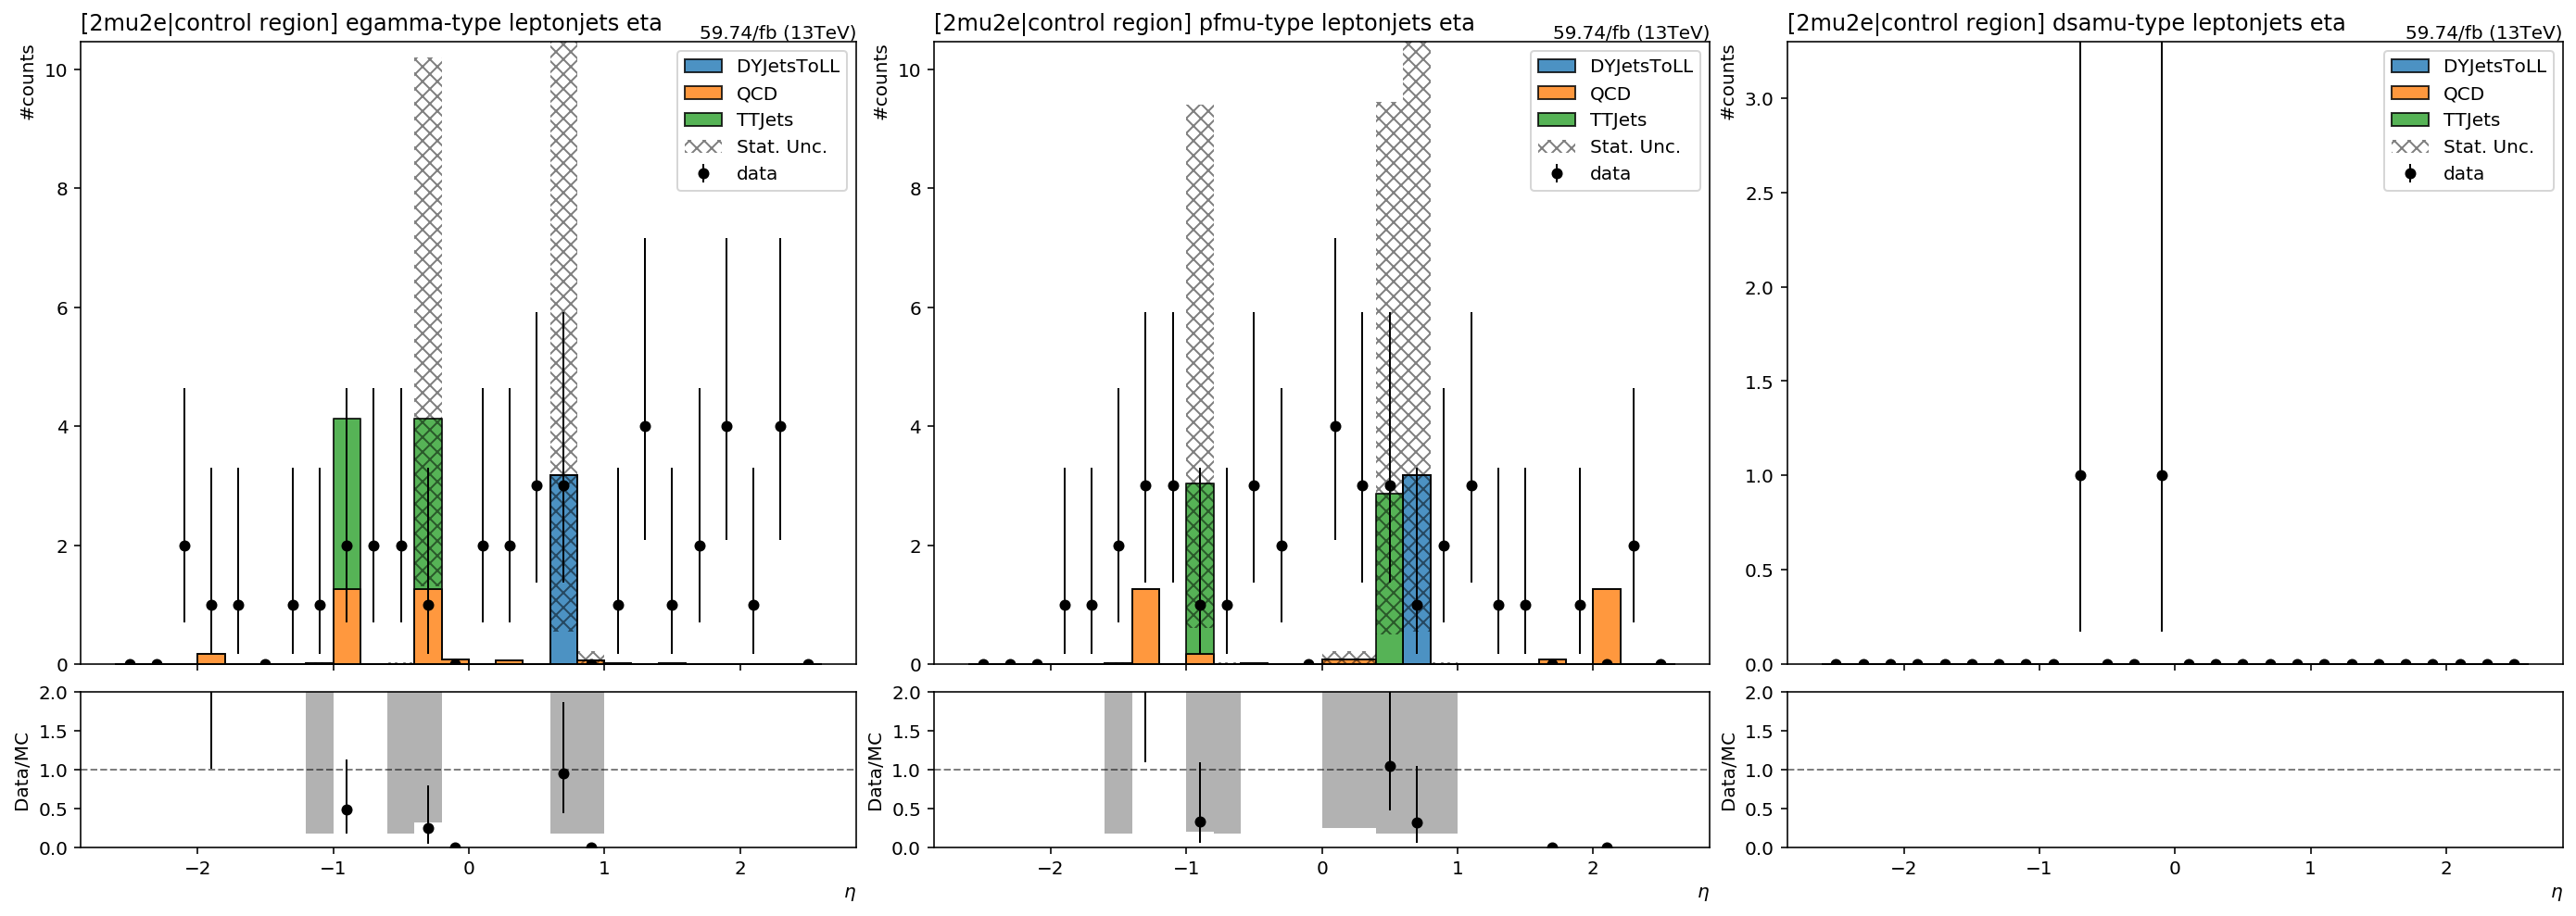

In [25]:
makeplot_2mu2e('ljeta_cat', 'eta', overflow='all', logy=False)

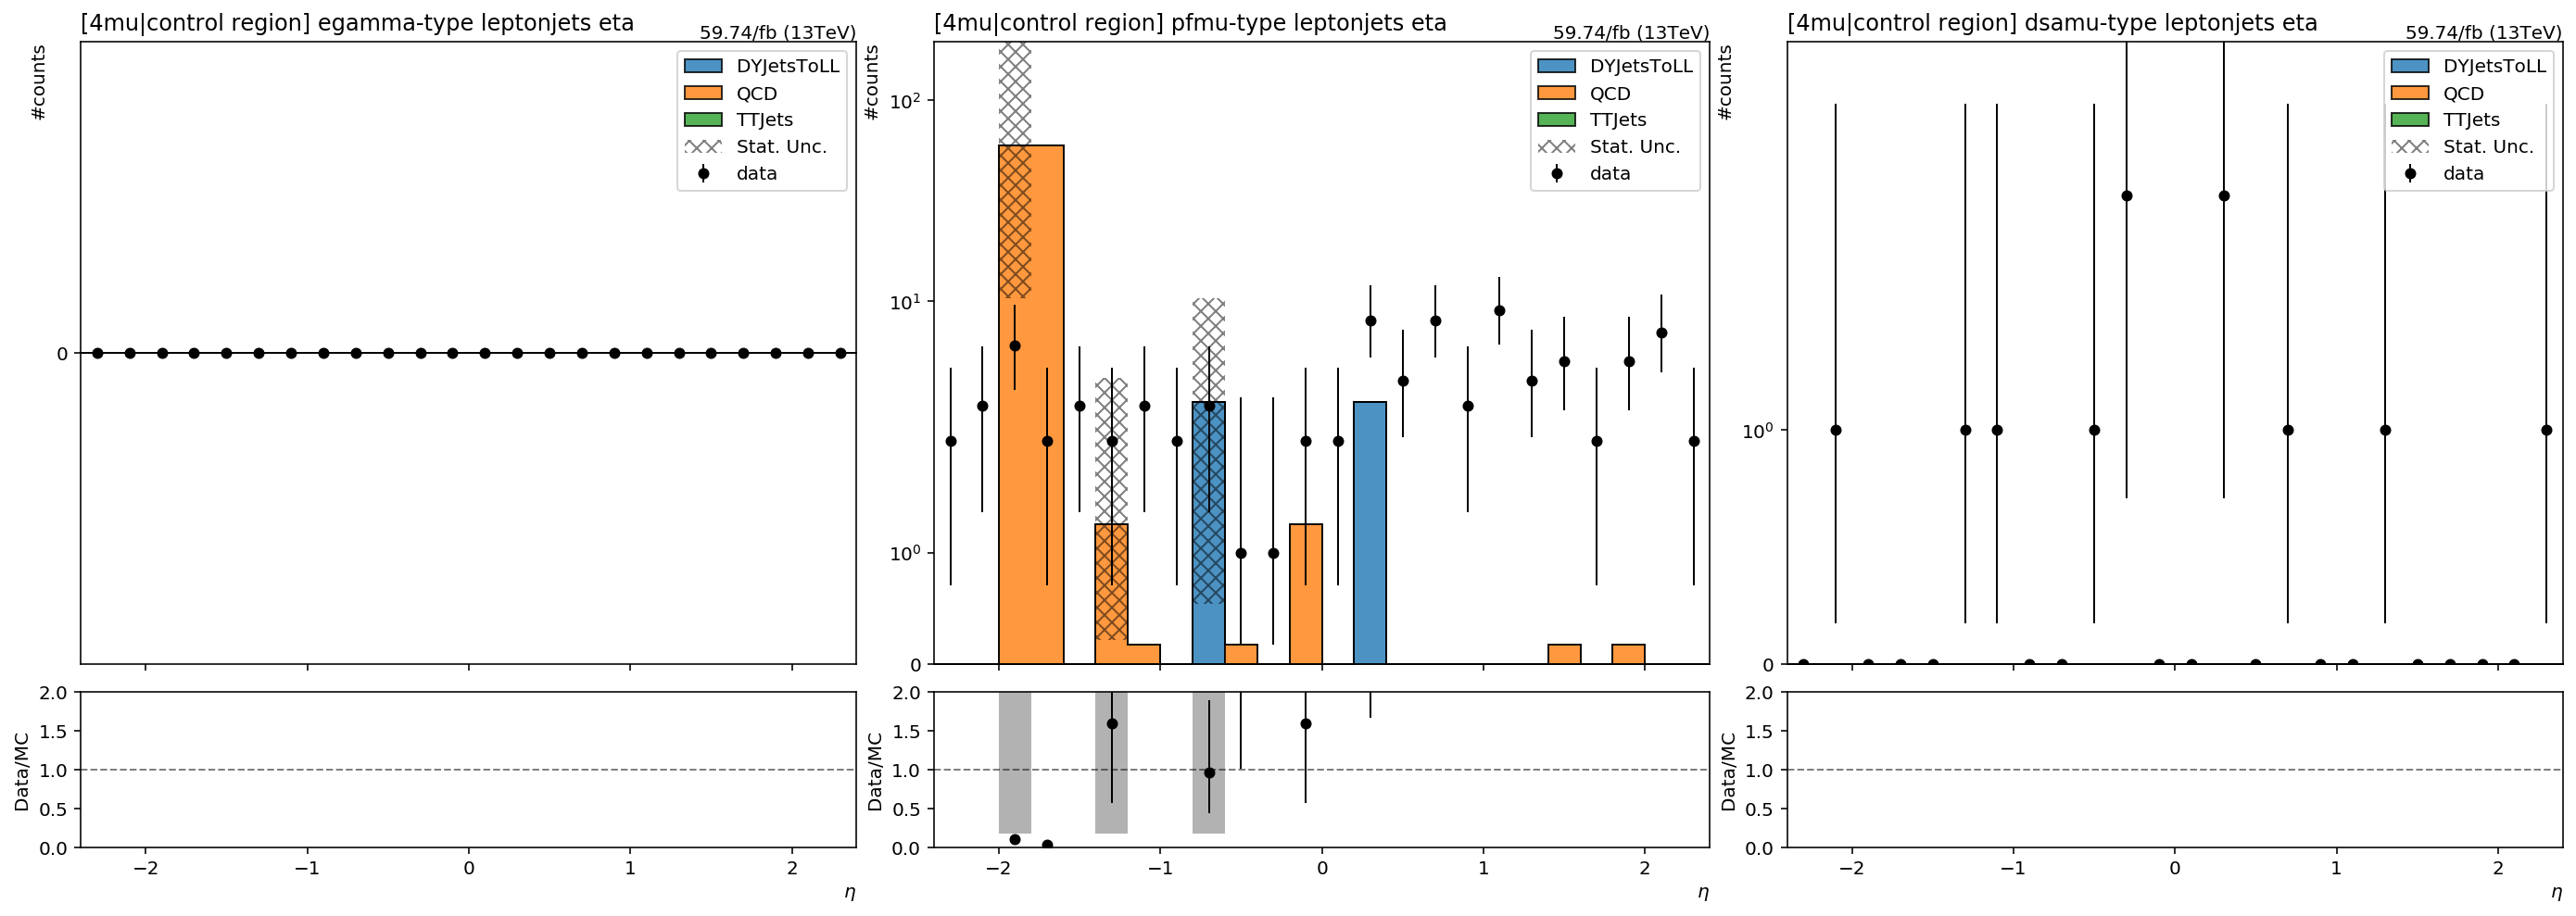

In [26]:
makeplot_4mu('ljeta_cat', 'eta', overflow='all', xlim=[-2.4, 2.4])

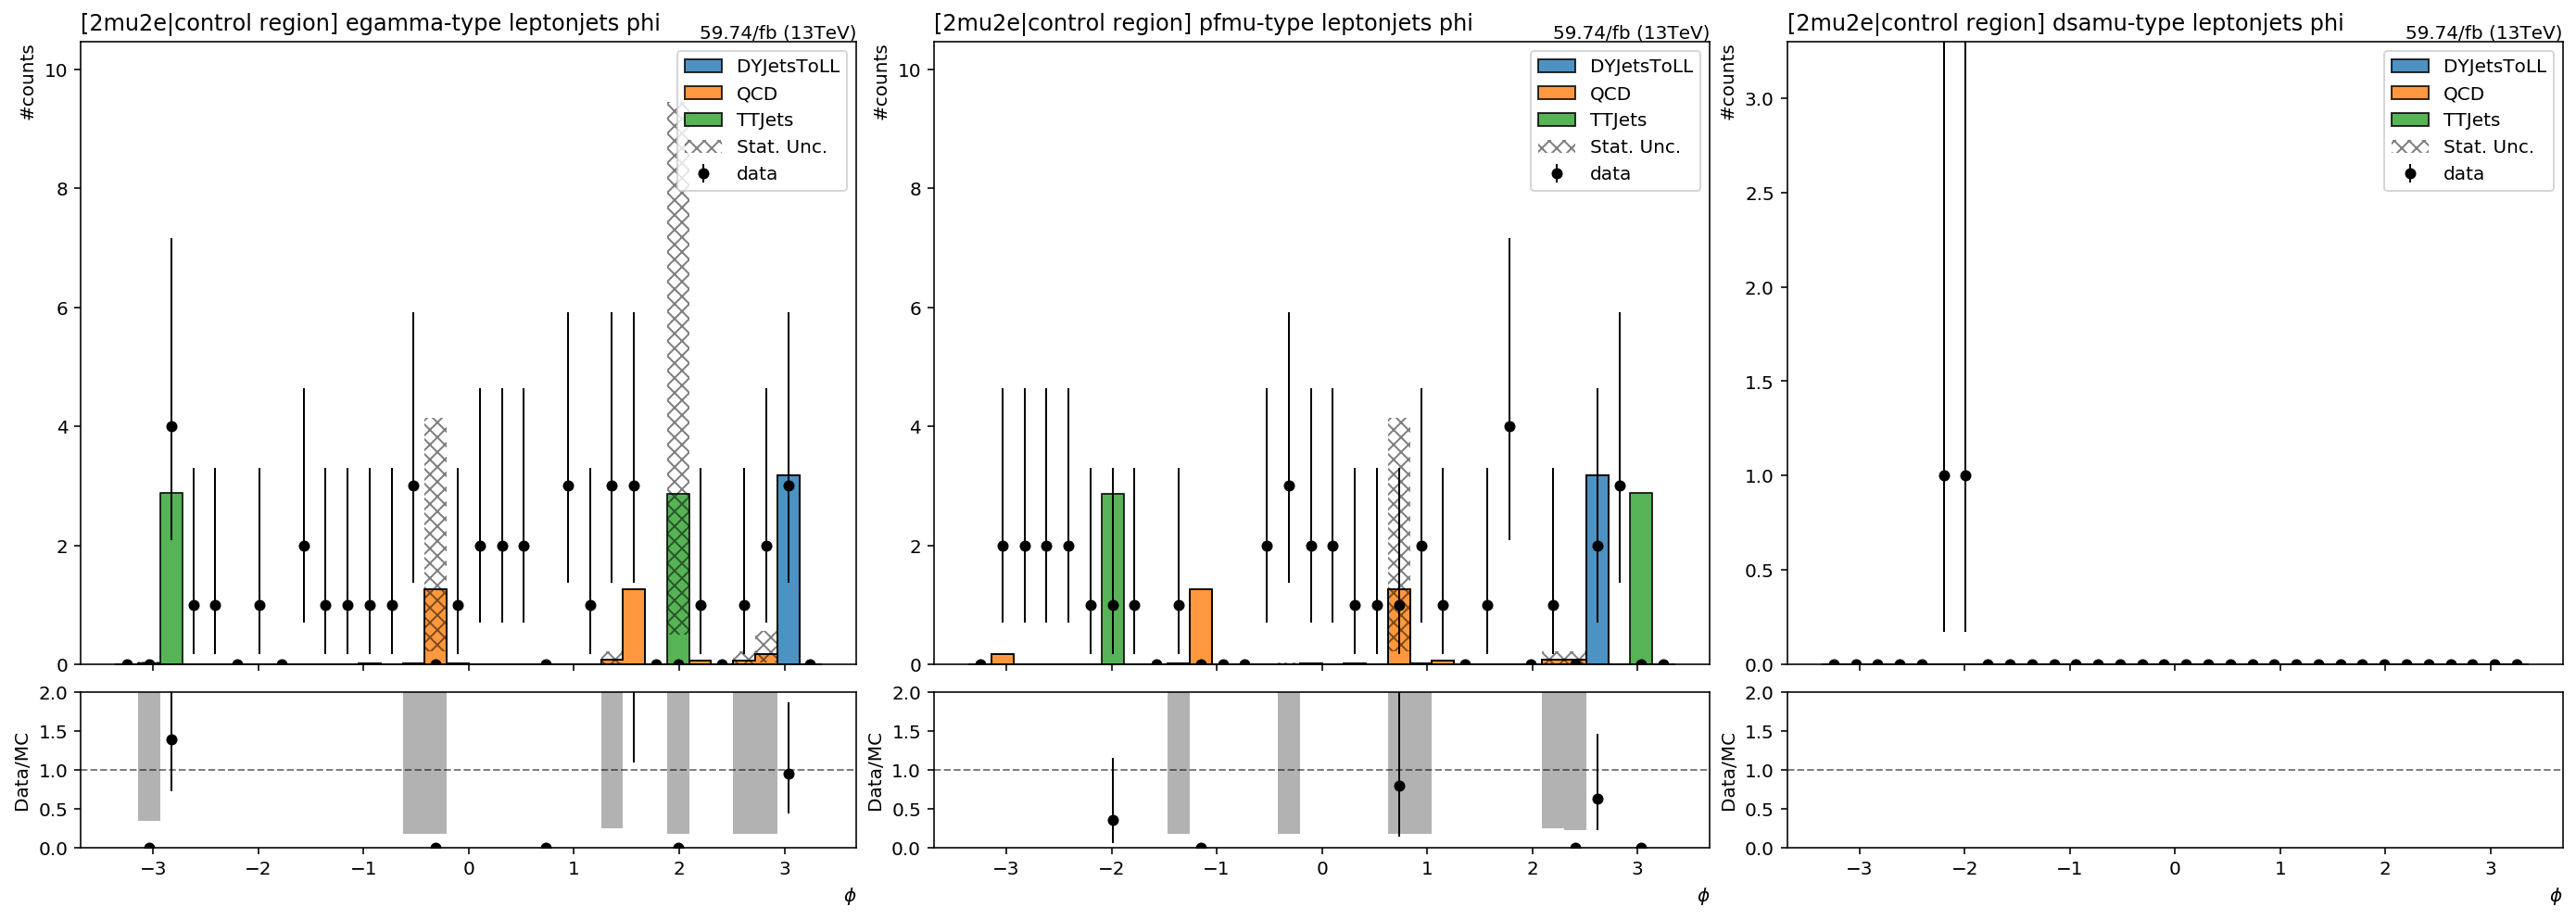

In [27]:
makeplot_2mu2e('ljphi_cat', 'phi', logy=False, overflow='all')

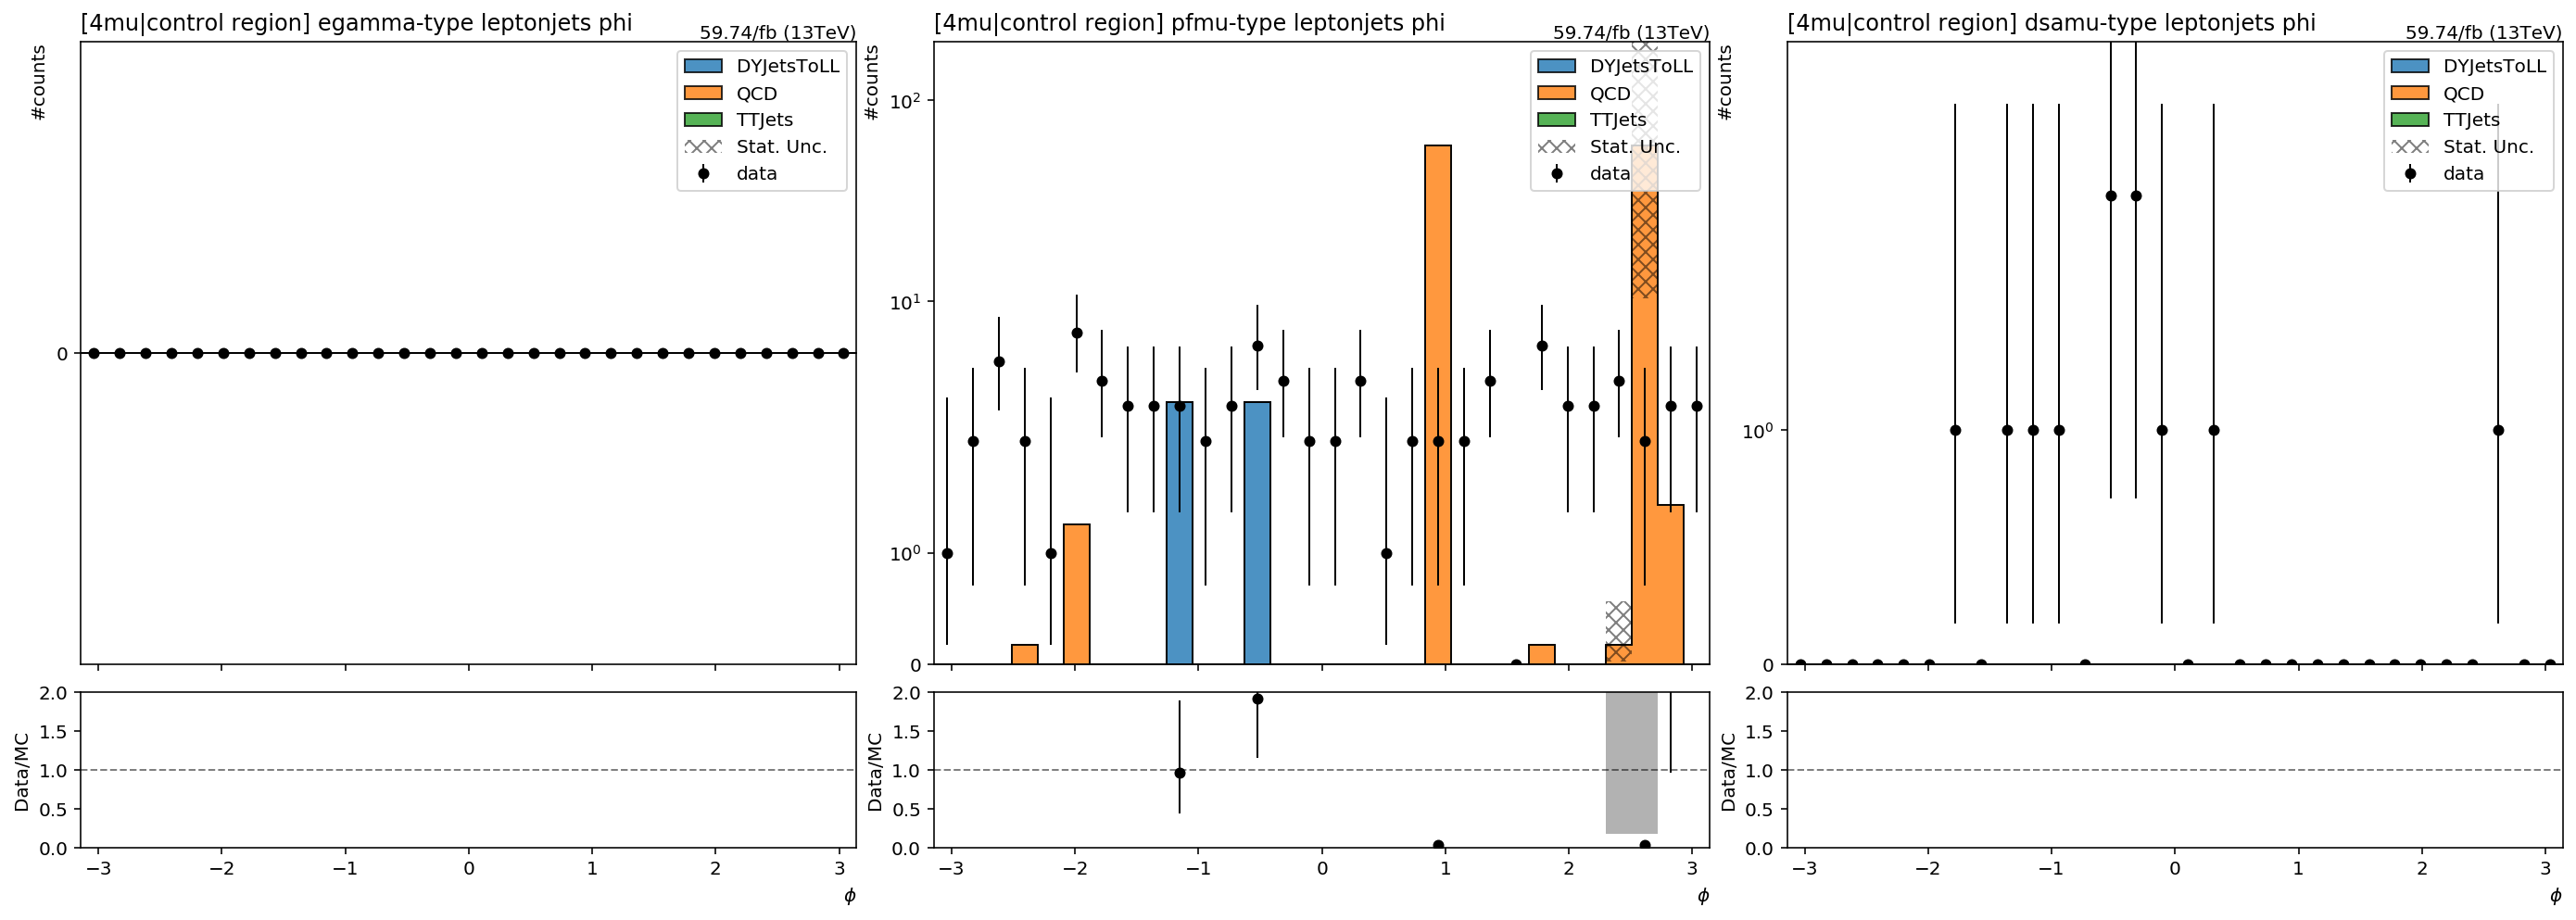

In [28]:
makeplot_4mu('ljphi_cat', 'phi', overflow='all', xlim=[-np.pi, np.pi])

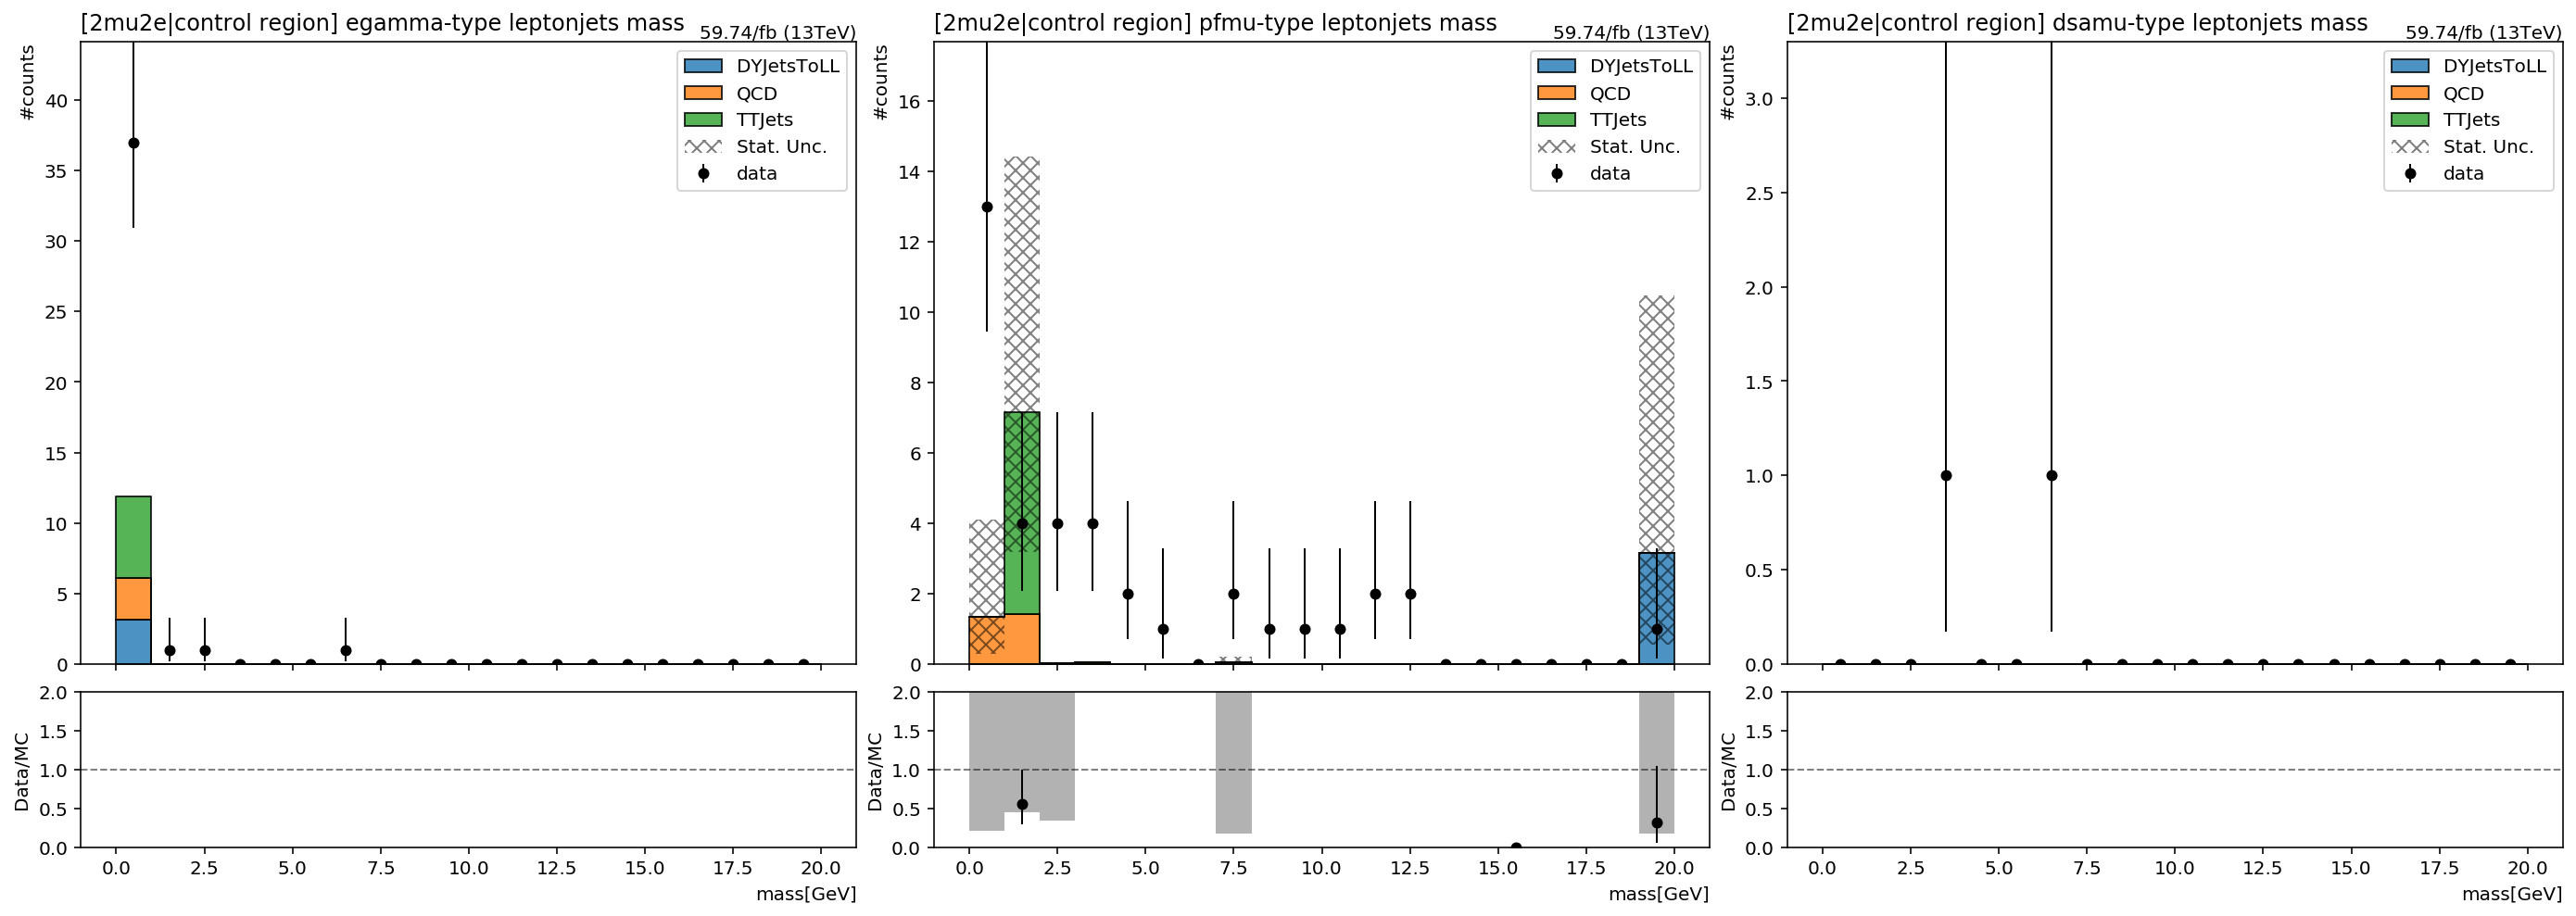

In [29]:
makeplot_2mu2e('ljmass_cat', 'mass', logy=False)

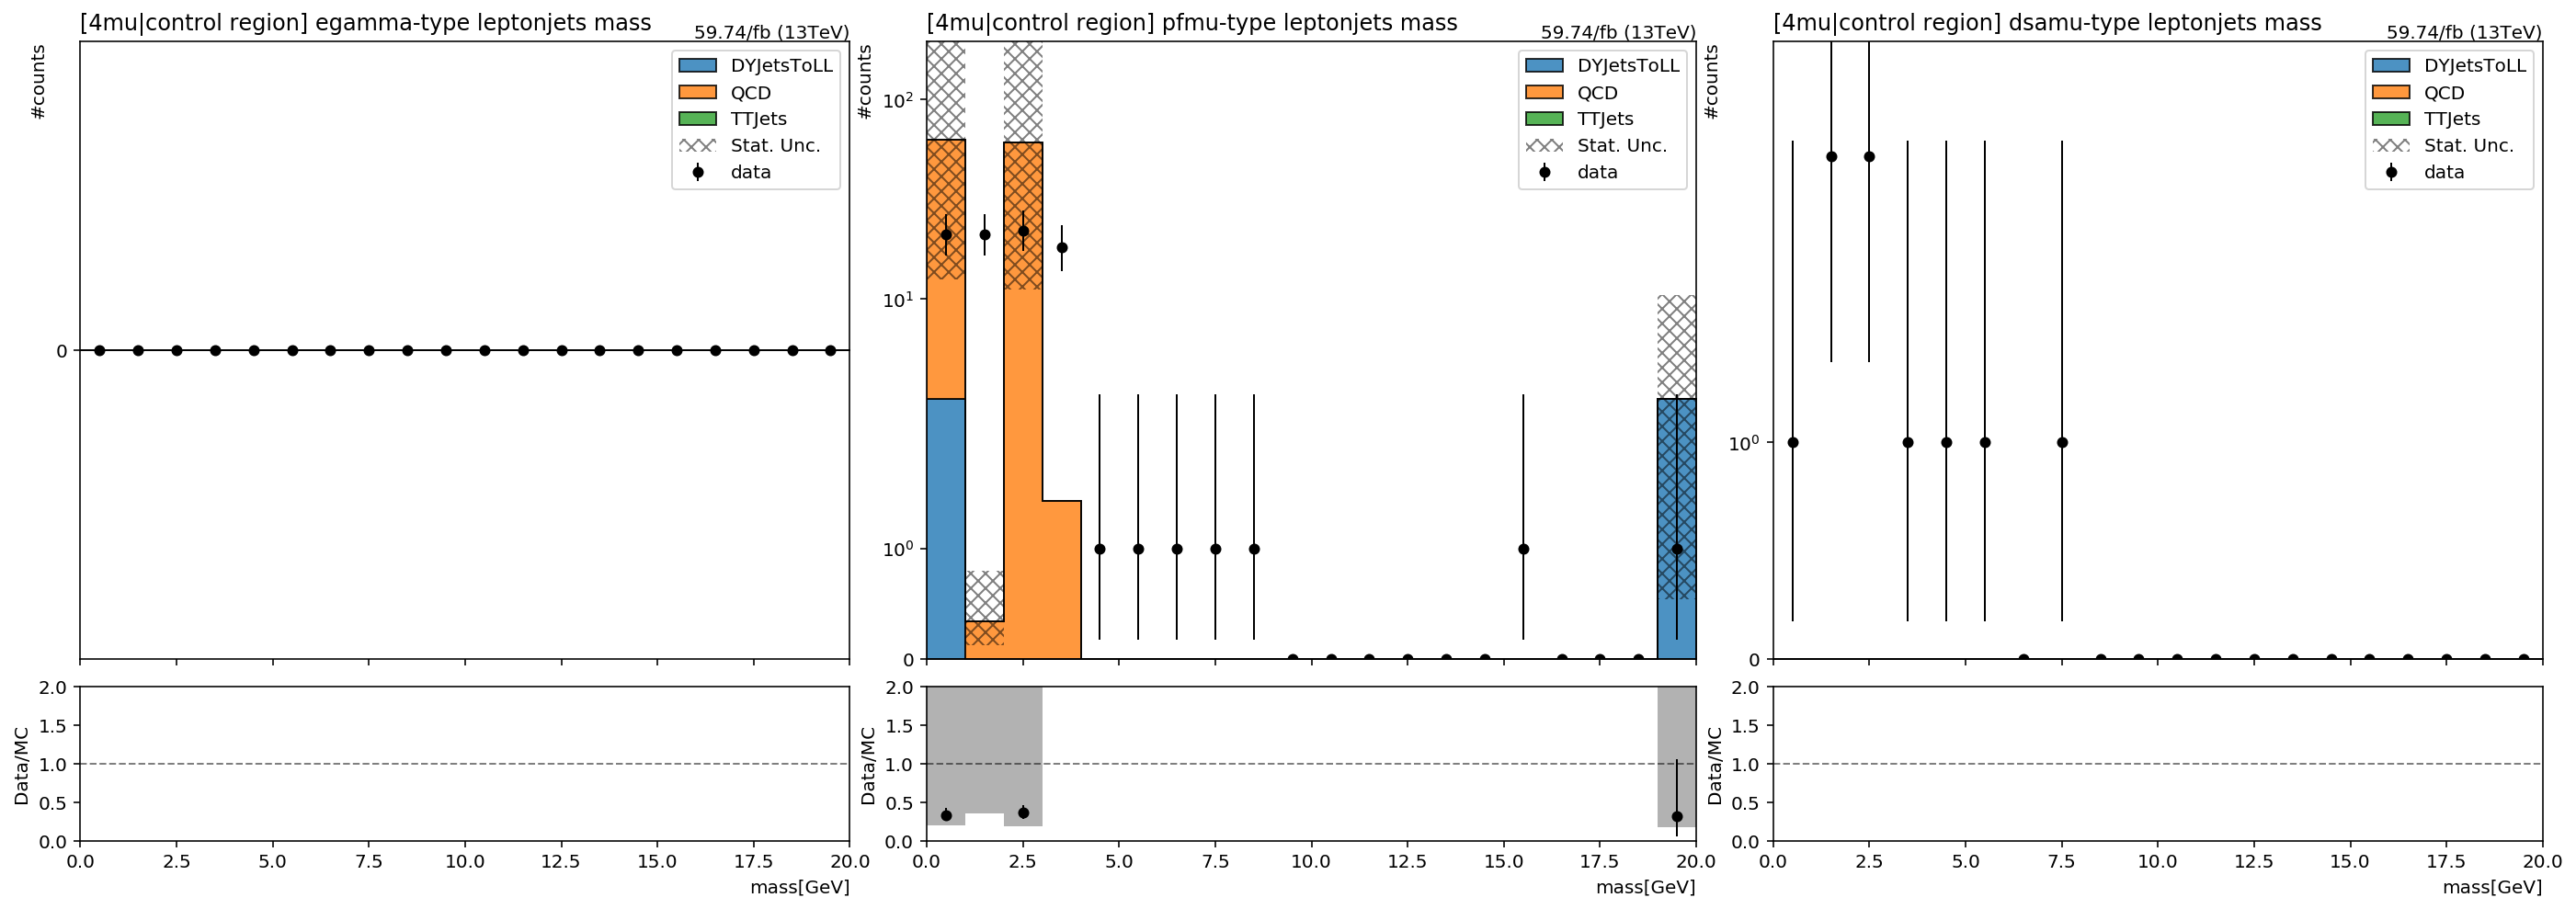

In [30]:
makeplot_4mu('ljmass_cat', 'mass', xlim=[0, 20])

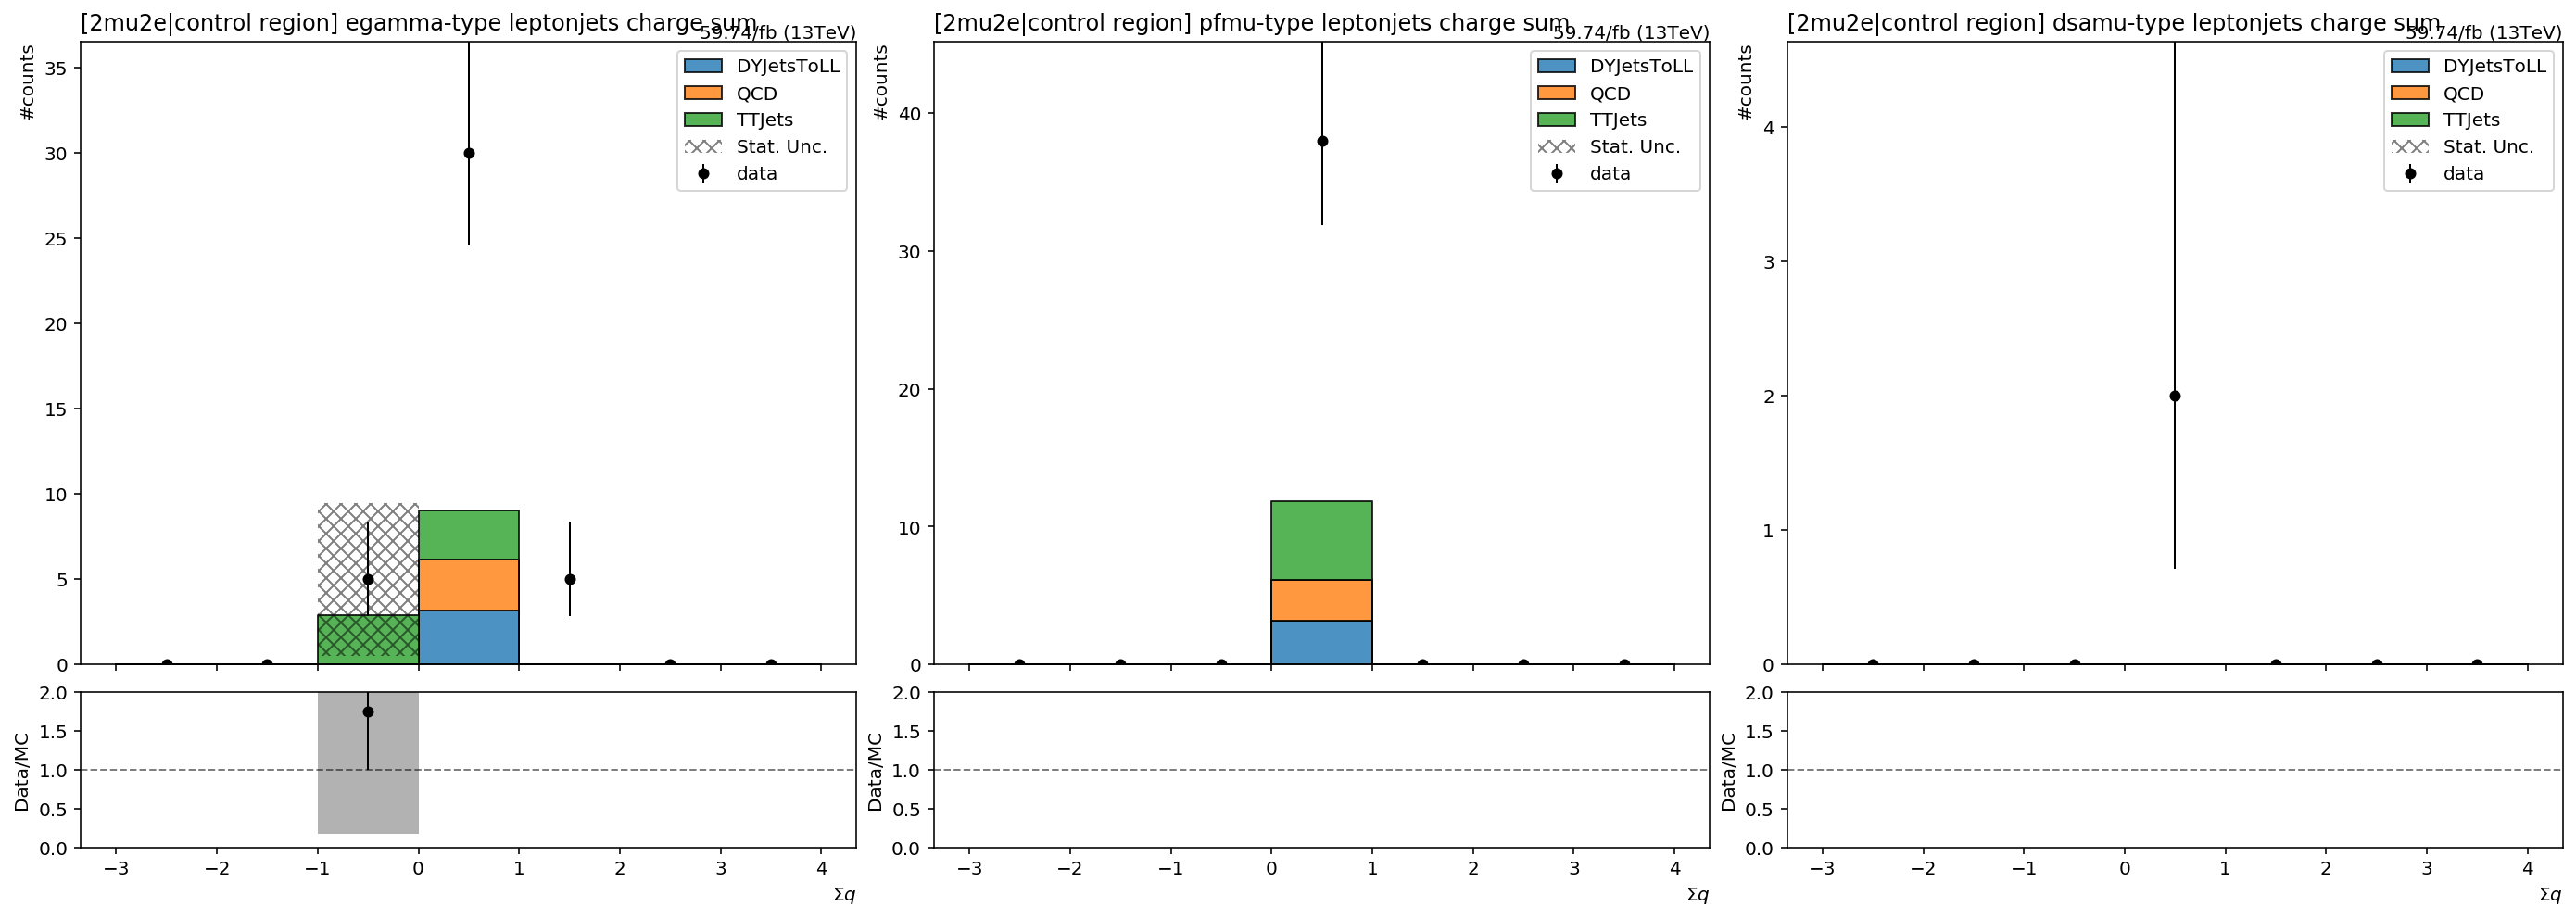

In [31]:
makeplot_2mu2e('ljqsum_cat', 'charge sum', logy=False, overflow='all')

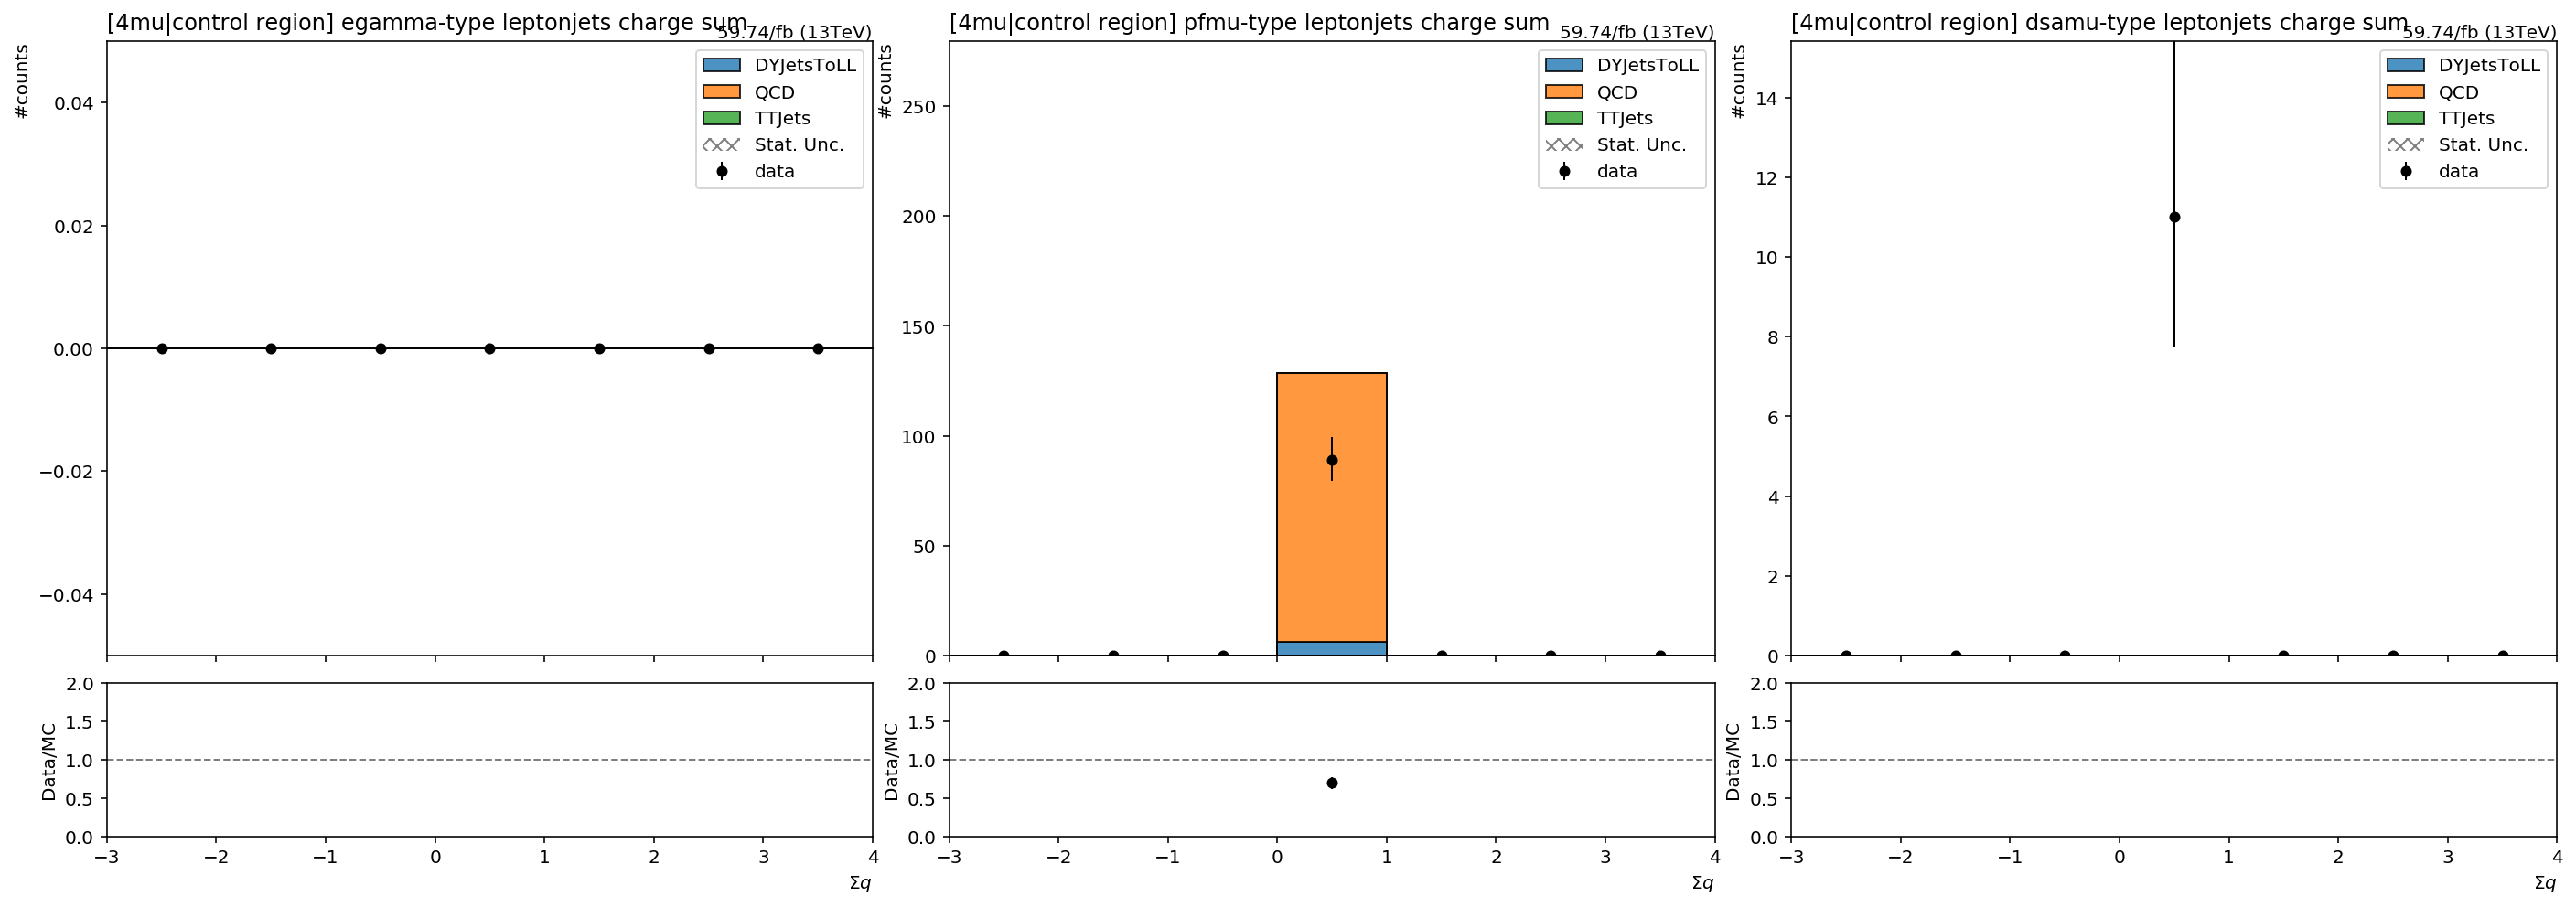

In [32]:
makeplot_4mu('ljqsum_cat', 'charge sum', logy=False, overflow='all', xlim=[-3,4])

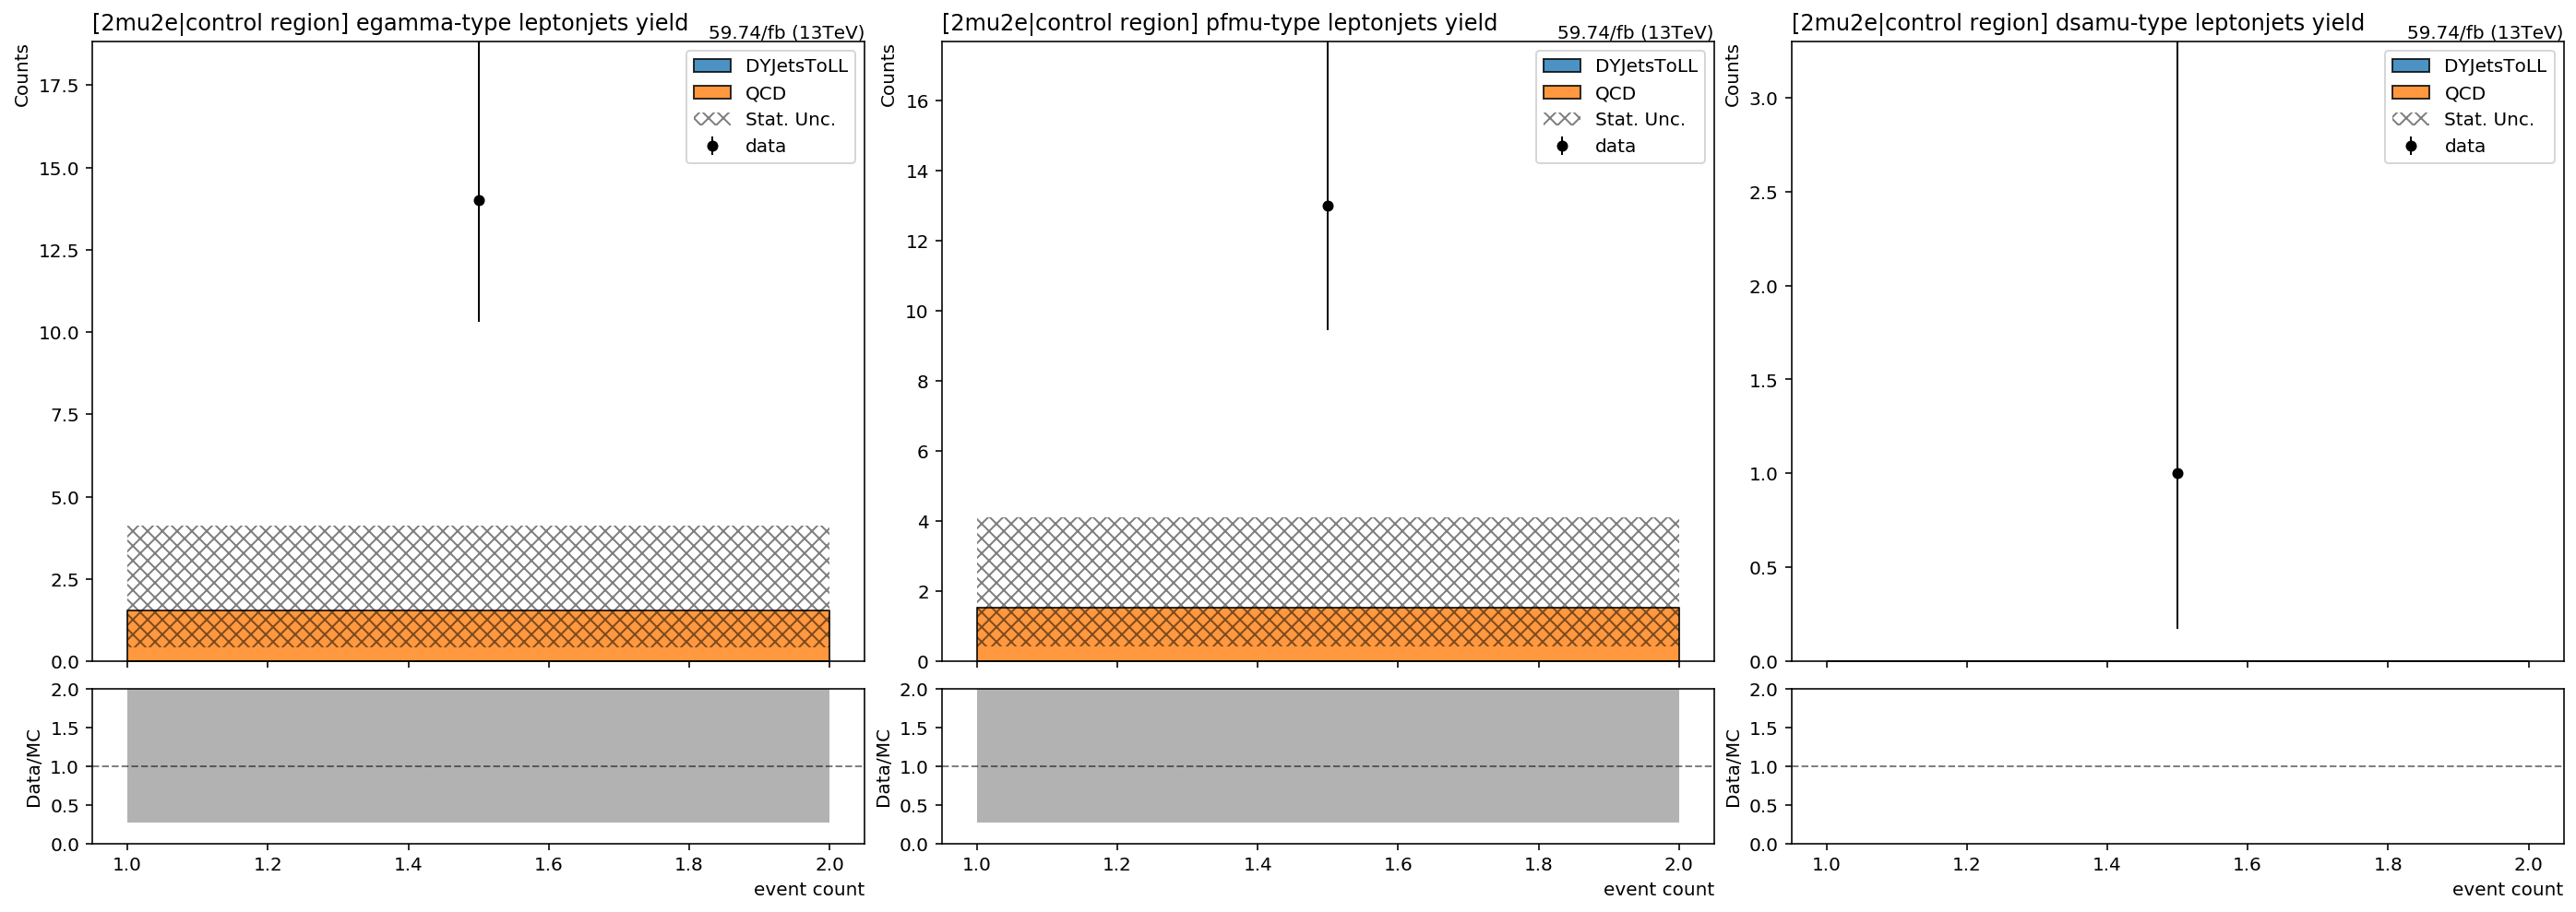

In [8]:
makeplot_2mu2e('ljcnt_cat', 'yield', logy=False, overflow='none', )

In [9]:
printYield_2mu2e()

,egamma,pfmu,dsamu
DYJetsToLL,0.00,0.00,0.0
QCD,1.53,1.53,0.0
data,14.00,13.00,1.0


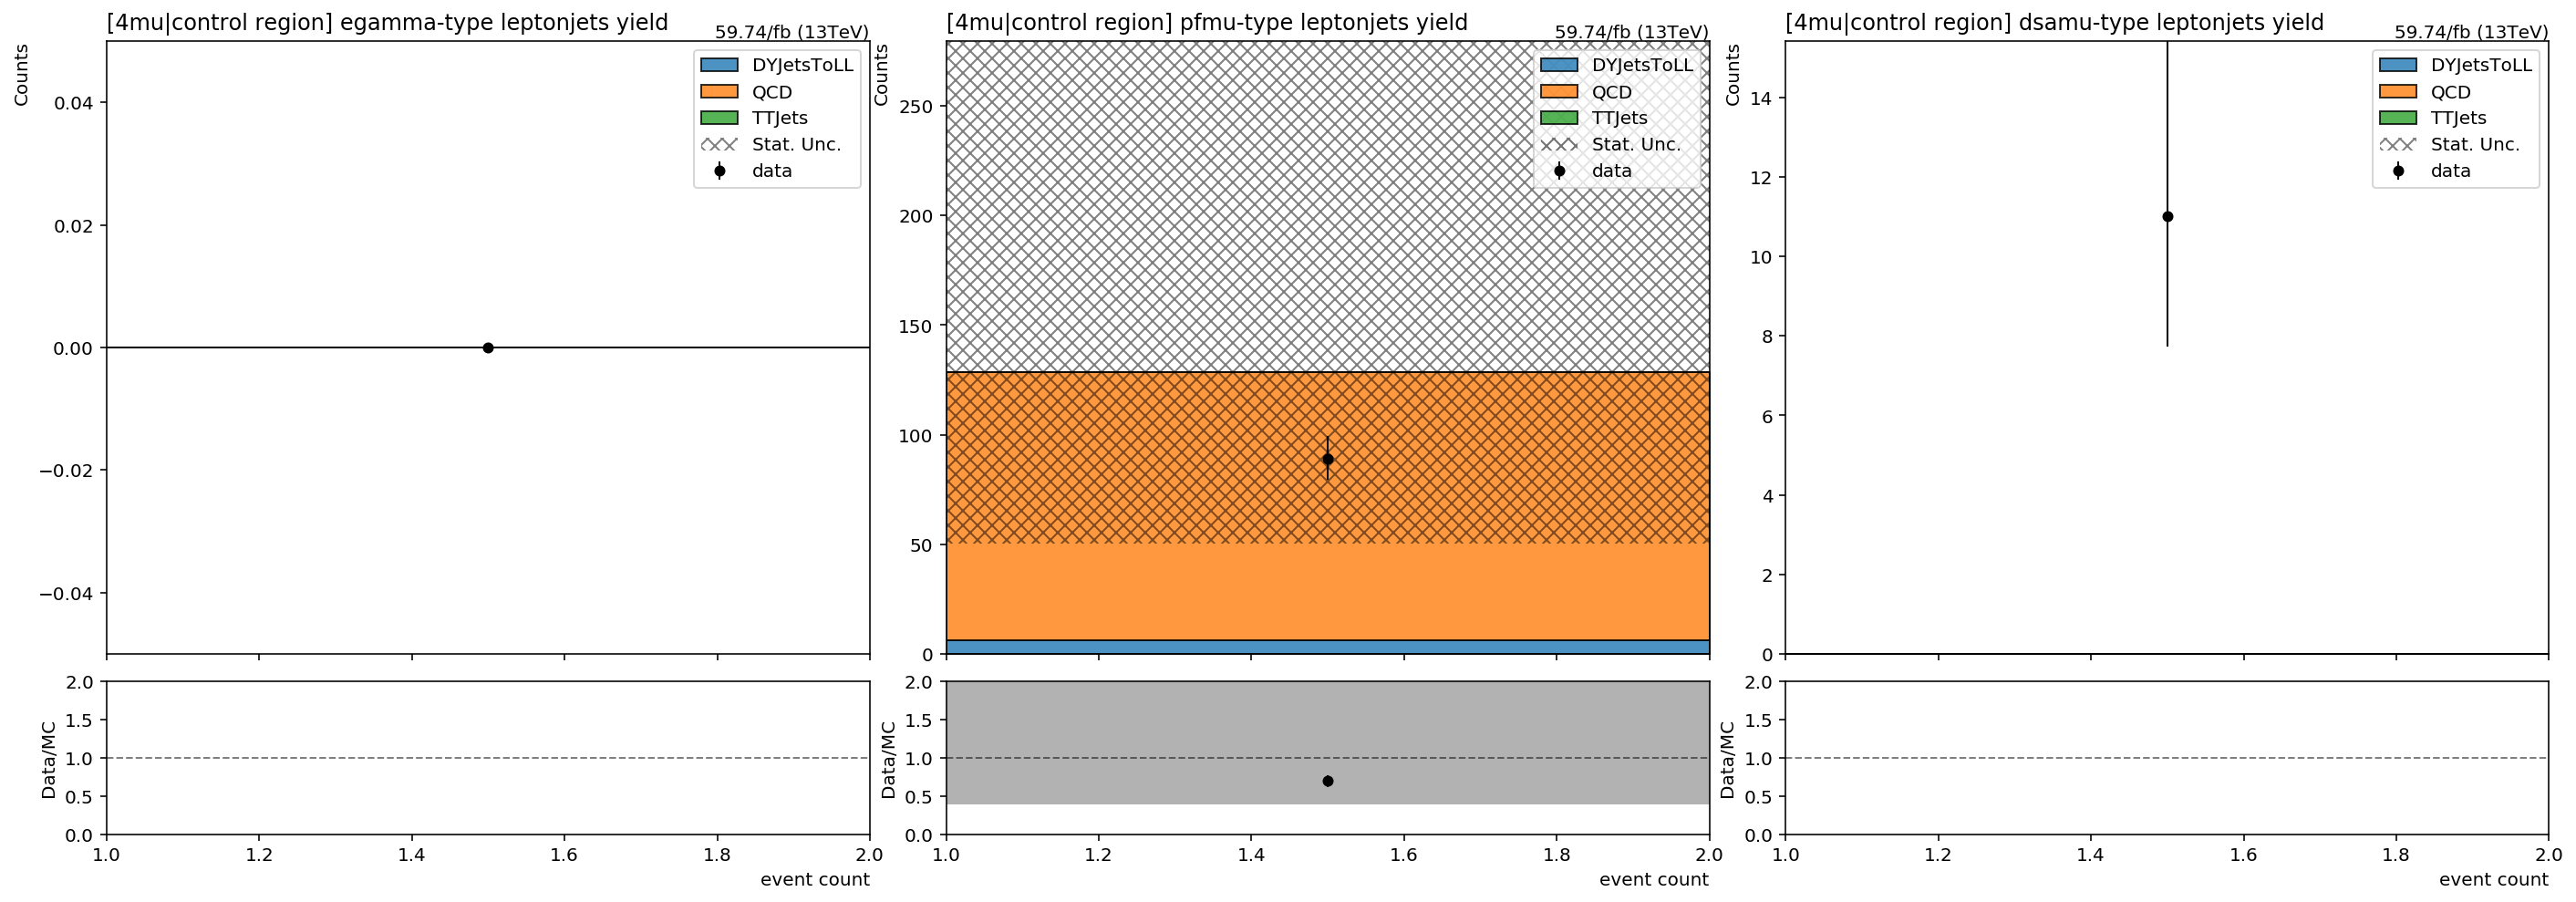

In [35]:
makeplot_4mu('ljcnt_cat', 'yield', logy=False, overflow='none', xlim=[1,2])

In [10]:
printYield_4mu()

,egamma,pfmu,dsamu
DYJetsToLL,0.0,6.28,0.0
QCD,0.0,122.20,0.0
data,0.0,89.00,11.0


In [12]:
def makeplotByChannel(plotvar, title, overflow='over', logy=True, ylim=None):
    fig, (axes, raxes) = plt.subplots(2,2,figsize=(16,8), sharex=True,
                                      gridspec_kw={"height_ratios": (4, 1)},)
    fig.subplots_adjust(hspace=.07, wspace=0.1)

    hist.plot1d(output[plotvar][notdata].integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[0],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('channel', slice(1,2)),
               overlay='cat',
               ax=axes[0],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('channel', slice(1,2)).sum('cat'),
                   output[plotvar][notdata].integrate('channel', slice(1,2)).sum('cat'),
                   ax=raxes[0],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    hist.plot1d(output[plotvar][notdata].integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[1],
               clear=False,
               stack=True,
               overflow=overflow,
               line_opts=None,
               fill_opts=fill_opts,
               error_opts=error_opts)
    hist.plot1d(output[plotvar]['data'].integrate('channel', slice(2,3)),
               overlay='cat',
               ax=axes[1],
               overflow=overflow,
               clear=False,
               error_opts=data_err_opts)
    hist.plotratio(output[plotvar]['data'].integrate('channel', slice(2,3)).sum('cat'),
                   output[plotvar][notdata].integrate('channel', slice(2,3)).sum('cat'),
                   ax=raxes[1],
                   overflow=overflow,
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num')

    for ax in axes:
        ax.autoscale(axis='both', tight=True)
        if logy:
            ax.set_yscale('symlog')
            ax.autoscale(axis='y', tight=True)
        if ylim:
            ax.set_ylim(*ylim)
        ax.set_xlabel(None)
        leg=ax.legend()
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        ax.text(1,1,'59.74/fb (13TeV)',
                ha='right', va='bottom', transform=ax.transAxes)

    for rax in raxes:
        rax.set_ylabel('Data/MC')
        rax.set_ylim(0,2)
        rax.set_xlabel(rax.get_xlabel(), x=1.0, ha="right")


    axes[0].set_title(f'[2mu2e|control region] leptonjets {title}', x=0.0, ha="left")
    axes[1].set_title(f'[4mu|control region] leptonjets {title}', x=0.0, ha="left")
    
#######################
from collections import defaultdict
import pandas as pd

def printYieldByChannel():
    result = defaultdict(dict)
    for i, name in enumerate(['2mu2e', '4mu'], start=1):
        histMC = output['eventcnt_cat'][notdata].integrate('channel', slice(i,i+1))
        histData = output['eventcnt_cat']['data'].integrate('channel', slice(i,i+1))
        for k, v in histMC.values().items():
            result[name][k[0]] = round(v[0], 2)
        for k, v in histData.values().items():
            result[name][k[0]] = round(v[0], 2)
    return pd.DataFrame(result)


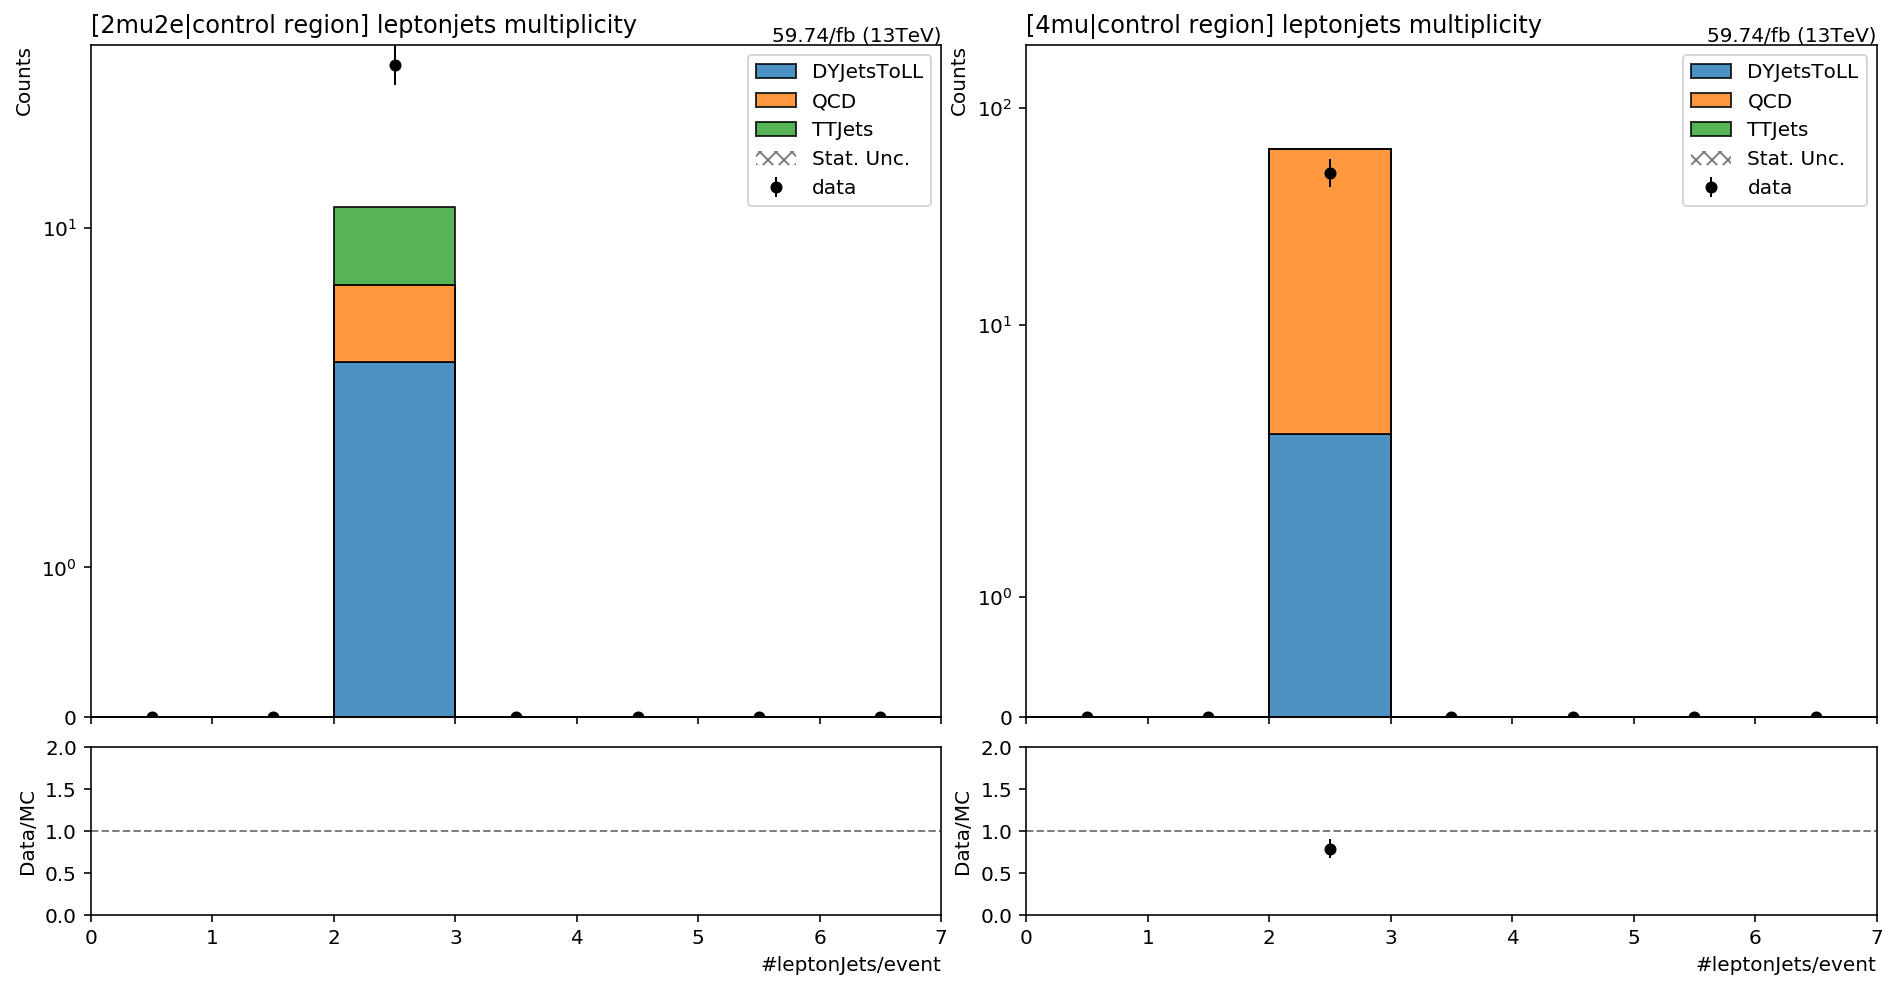

In [38]:
makeplotByChannel('multi_cat', 'multiplicity')

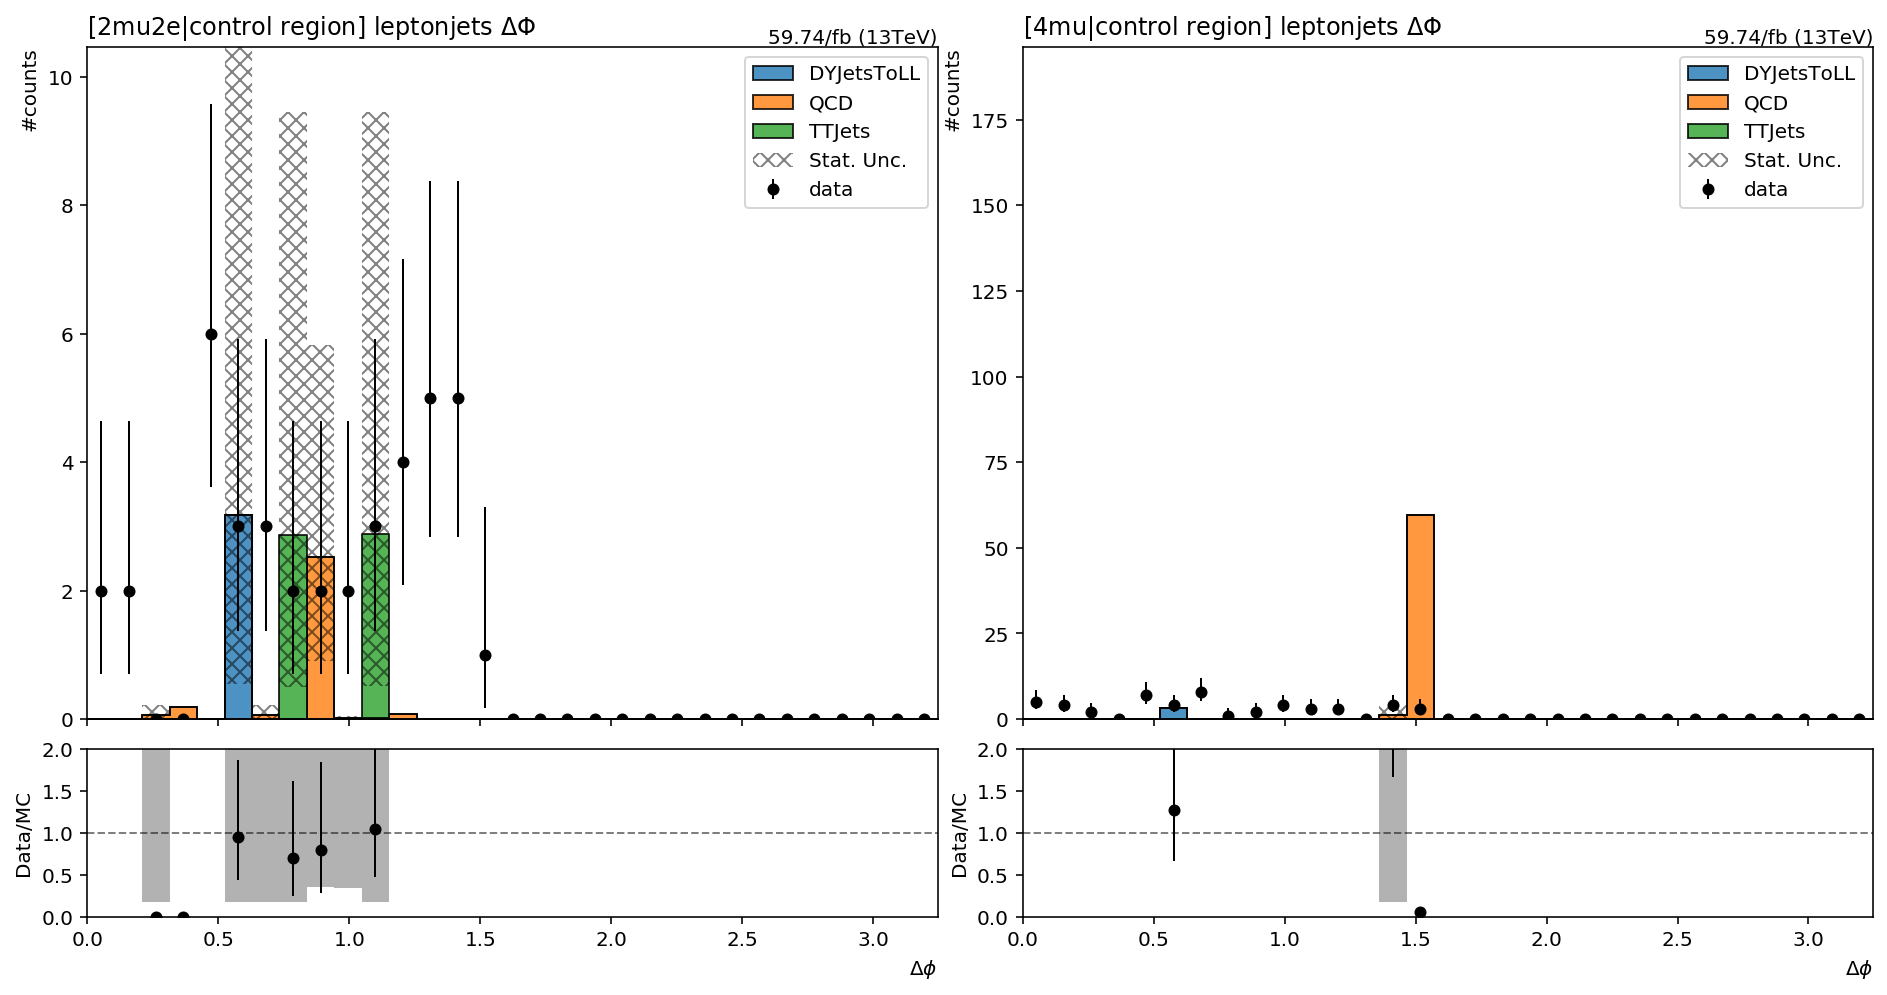

In [39]:
makeplotByChannel('ljpair_cat', '$\Delta\Phi$', logy=False, )

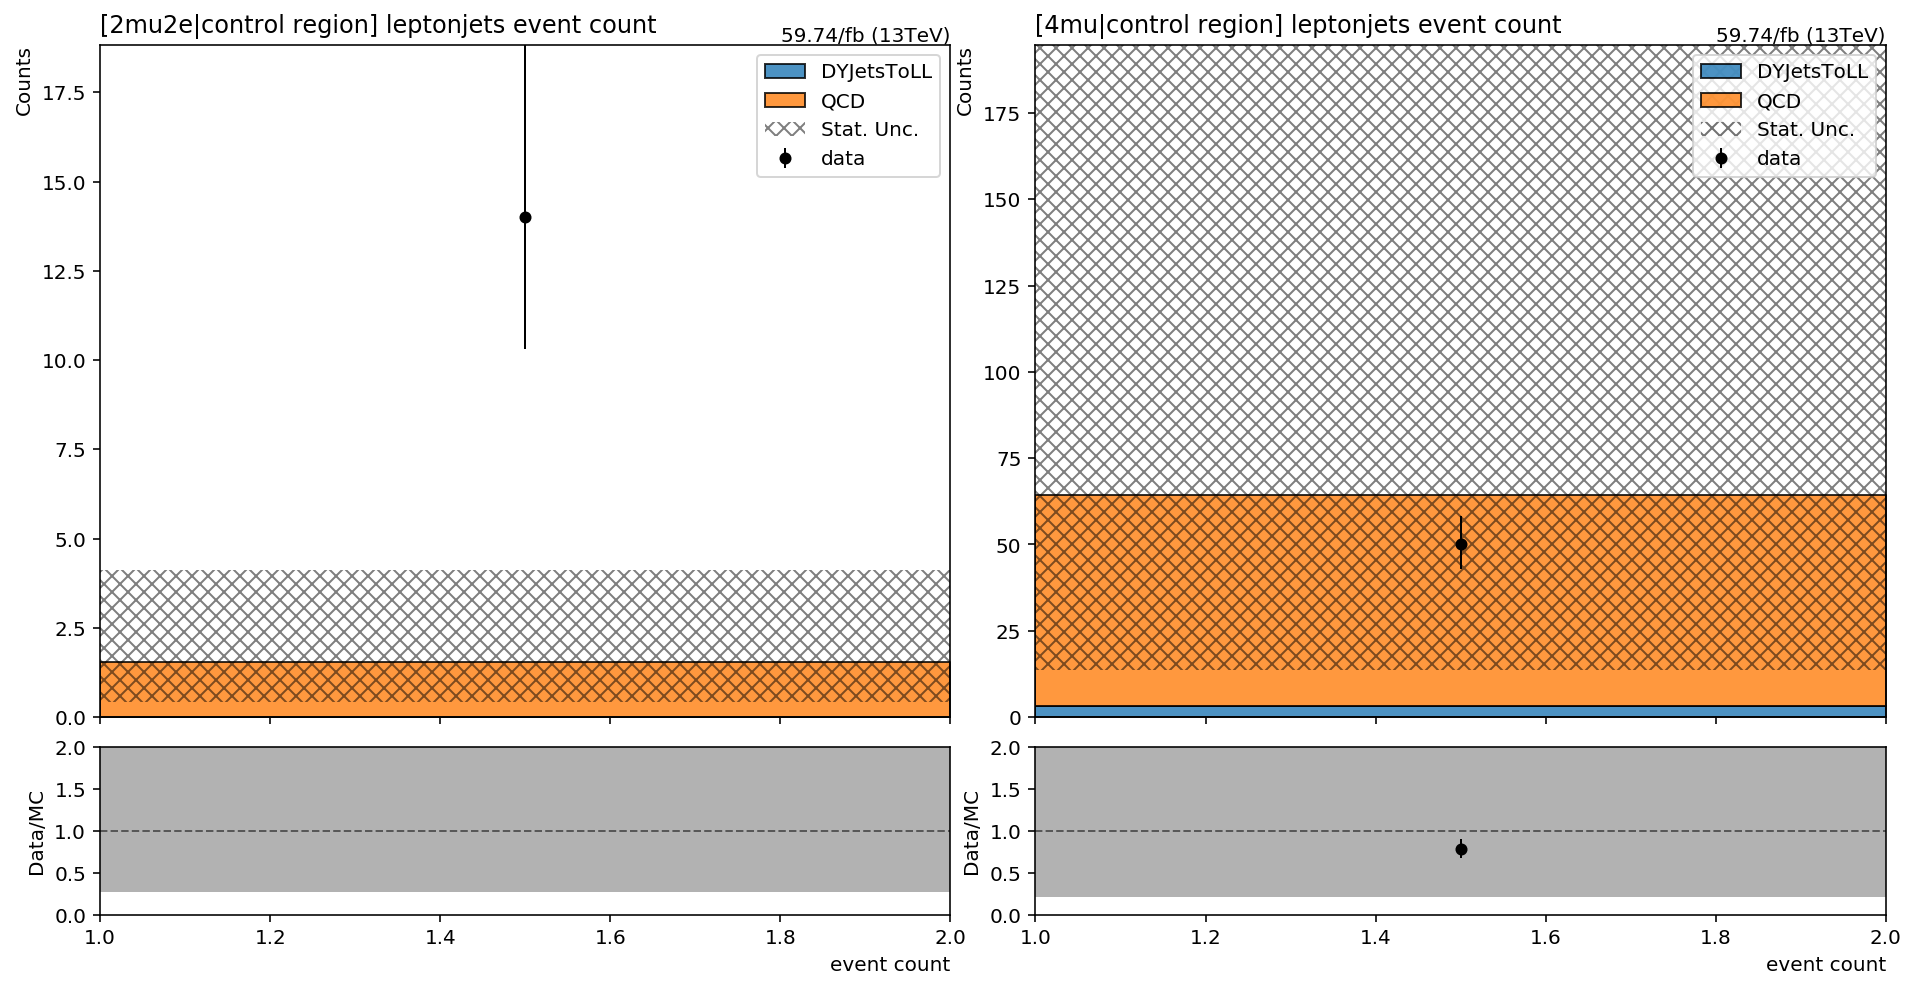

In [13]:
makeplotByChannel('eventcnt_cat', 'event count', overflow='none', logy=False)

In [14]:
printYieldByChannel()

,2mu2e,4mu
DYJetsToLL,0.00,3.14
QCD,1.53,61.10
data,14.00,50.00


# print out eventlist of bkg (all regions) and data (control regions)

In [42]:
ptbinning = np.concatenate([np.arange(0, 300, 10),])
massbinning = np.concatenate([np.arange(0, 20, 1),])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 6, 0, 6)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 24, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 30, -np.pi, np.pi)
        qsum_axis = hist.Bin('qsum', '$\Sigma q$', 5, -2, 3)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 30, 0, np.pi)
        label_axis = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        count_axis = hist.Bin('cnt', 'event count', 1, 1, 2)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'ljpt': hist.Hist("#counts", dataset_axis, pt_axis, label_axis, channel_axis),
            'ljeta': hist.Hist("#counts", dataset_axis, eta_axis, label_axis, channel_axis),
            'ljphi': hist.Hist("#counts", dataset_axis, phi_axis, label_axis, channel_axis),
            'ljmass': hist.Hist("#counts", dataset_axis, mass_axis, label_axis, channel_axis),
            'ljqsum': hist.Hist("#counts", dataset_axis, qsum_axis, label_axis, channel_axis),
            "ljpair": hist.Hist("#counts", dataset_axis, dphi_axis, channel_axis),
            'eventcnt': hist.Hist("Counts", dataset_axis, count_axis, channel_axis),
            'ljcnt': hist.Hist("Counts", dataset_axis, count_axis, label_axis, channel_axis),
            
            'run_1': processor.column_accumulator(np.zeros(shape=(0,))),
            'lumi_1': processor.column_accumulator(np.zeros(shape=(0,))),
            'event_1': processor.column_accumulator(np.zeros(shape=(0,))),
            'run_2': processor.column_accumulator(np.zeros(shape=(0,))),
            'lumi_2': processor.column_accumulator(np.zeros(shape=(0,))),
            'event_2': processor.column_accumulator(np.zeros(shape=(0,))),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']
        run = df['run']
        lumi = df['lumi']
        event = df['event']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            pfiso=df['pfjet_pfIsolation05'],
            ncands=df['pfjet_pfcands_n']
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        leptonjets.add_attributes(isoeg=(leptonjets.ismutype | (leptonjets.iseltype&((leptonjets.pfiso<0.1) | (leptonjets.ncands>=2)))))
        leptonjets = leptonjets[leptonjets.isneutral&leptonjets.isoeg]
                
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        run = run[twoleptonjets]
        lumi = lumi[twoleptonjets]
        event = event[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        output['run_1'] += processor.column_accumulator(run[channel_==1])
        output['lumi_1'] += processor.column_accumulator(lumi[channel_==1])
        output['event_1'] += processor.column_accumulator(event[channel_==1])
        output['run_2'] += processor.column_accumulator(run[channel_==2])
        output['lumi_2'] += processor.column_accumulator(lumi[channel_==2])
        output['event_2'] += processor.column_accumulator(event[channel_==2])
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
#         leptonjets_ = dileptonjets[isControl]
#         if leptonjets_.size==0: return output
#         wgt = wgt[isControl]
#         lj0 = lj0[isControl]
#         lj1 = lj1[isControl]
#         channel_ = channel_[isControl]
        
#         if dataset.startswith('QCD') and wgt[channel_==2].size>0:
#             run = df['run'][twoleptonjets][isControl&(channel_==2)]
#             lumi = df['lumi'][twoleptonjets][isControl&(channel_==2)]
#             event = df['event'][twoleptonjets][isControl&(channel_==2)]
#             for r, l, e in np.nditer([run, lumi, event]):
#                 print(f'{dataset} | {r}:{l}:{e} -- weight: {wgt}')
#             if dataset=='QCD_Pt-120to170':
#                 print(f'weight: {wgt}')
            
#         output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt, channel=channel_)
#         output['eventcnt'].fill(dataset=dataset, cnt=np.ones_like(wgt), weight=wgt, channel=channel_)
#         ljwgt = (leptonjets_.pt.ones_like()*wgt).flatten()
#         ljchannel = (leptonjets_.pt.ones_like()*channel_).flatten()
#         output['ljpt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljeta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljphi'].fill(dataset=dataset, phi=leptonjets_.phi.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljmass'].fill(dataset=dataset, mass=leptonjets_.mass.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljqsum'].fill(dataset=dataset, qsum=leptonjets_.qsum.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljcnt'].fill(dataset=dataset, cnt=np.ones_like(ljwgt), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        
#         output['ljpair'].fill(dataset=dataset, dphi=np.abs(lj0.p4.delta_phi(lj1.p4)).flatten(), weight=wgt, channel=channel_)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            if isinstance(accumulator[k], hist.Hist):
                accumulator[k].scale(bkgscales, axis='dataset')
                accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                             hist.Cat("cat", "datasets"),
                                                             mapping)
        return accumulator

In [43]:
outputs={}
for k in datasets:
    outputs[k] = processor.run_uproot_job({k: datasets[k]},
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 1/1 [00:01<00:00,  1.00s/items]
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/hist_tools.py:307: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f64501b7438>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
Processing: 100%|██████████| 1/1 [00:01<00:00,  1.00s/items]
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/hist_tools.py:307: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f64501b7128>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
Processing: 100%|██████████| 1/1 [00:01<00:00,  1.00s/items]
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/hist_tools.py:307: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f642ce01908>
  warnings.war

In [44]:
print('## 2mu2e channel:')
for k, output in outputs.items():
    runs, lumis, events = output['run_1'].value.astype(int), output['lumi_1'].value.astype(int), output['event_1'].value.astype(int)
    print(f'\n{k}')
    if runs.size==0: continue
    for r,l,e in np.nditer([runs, lumis, events]):
        print('{}:{}:{}'.format(r, l, e))

print('## 4mu channel:')
for k, output in outputs.items():
    runs, lumis, events = output['run_2'].value.astype(int), output['lumi_2'].value.astype(int), output['event_2'].value.astype(int)
    print(f'\n{k}')
    if runs.size==0: continue
    for r,l,e in np.nditer([runs, lumis, events]):
        print('{}:{}:{}'.format(r, l, e))

## 2mu2e channel:

QCD_Pt-80to120
1:9862:240631817

QCD_Pt-120to170
1:12782:326881175

QCD_Pt-170to300

QCD_Pt-300to470
1:2569:19380067
1:6137:46305630
1:5460:41196936
1:10116:76333281

QCD_Pt-470to600
1:3415:65336484
1:3011:57606176

QCD_Pt-600to800
1:1210:22156268
1:1719:31468471
1:3857:70630341
1:3864:70762551
1:8003:146558057
1:6971:127656771

QCD_Pt-800to1000
1:44:248534
1:12088:68917475
1:4963:28294848
1:4943:28180069
1:17687:100847113
1:19043:108574541
1:7348:41890488
1:8178:46627420

QCD_Pt-1000toInf
1:6449:82968571
1:566:7280852
1:1832:23559377
1:4325:55636938

DYJetsToLL_M-50
1:11004:25021969
1:15892:36137722

TTJets
1:12297:5041648
1:20168:8268745
1:10327:4233818

A
316457:931:1074952328
316505:637:782268090
315689:535:605129148
316114:62:69254911
316201:180:232276826
316239:487:607346539
316240:276:387143575
316380:998:821402086

B
317182:1261:1797323342
317640:817:1206317317

C
319524:839:1237646049
320040:727:1132109007
319854:88:130456803

D
320824:604:936192976
321760:5

In [52]:
eventlist = defaultdict(list)

for k, output in outputs.items():
    runs, lumis, events = output['run_1'].value.astype(int), output['lumi_1'].value.astype(int), output['event_1'].value.astype(int)
    #print(f'\n{k}')
    if runs.size==0: continue
    for r,l,e in np.nditer([runs, lumis, events]):
        eventlist[k].append('{}:{}:{}'.format(r, l, e))

print('## 4mu channel:')
for k, output in outputs.items():
    runs, lumis, events = output['run_2'].value.astype(int), output['lumi_2'].value.astype(int), output['event_2'].value.astype(int)
#     print(f'\n{k}')
    if runs.size==0: continue
    for r,l,e in np.nditer([runs, lumis, events]):
        eventlist[k].append('{}:{}:{}'.format(r, l, e))

for k in sorted(eventlist):
    print('\n-- ',k)
    print(*eventlist[k], sep='\n')

## 4mu channel:

--  A
315689:535:605129148
315770:58:39585194
316114:62:69254911
316201:180:232276826
316239:487:607346539
316240:276:387143575
316457:931:1074952328
316380:998:821402086
316505:637:782268090
315713:383:504286696
315420:539:397034837
315420:1339:820396149
315420:1424:856838529
315420:672:479907487
315488:235:223985592
315510:82:92509678
315543:58:23233031
315512:656:523619327
315840:260:318335681
315267:185:179362246
315645:335:333861305
316153:419:552566829
316569:1219:1662895210
315689:530:600441896
316059:503:515239741
315689:587:656755676
315785:105:139300980
315721:98:118874639
315785:177:227335122
315705:571:373045624
315840:221:265381316
315800:445:551422402
315840:754:874954239
315973:846:948237887
316469:399:501106650
316187:830:1134304941
316187:1279:1746277432
316666:272:366332734
316876:96:110530802
316240:172:246505399
316239:370:469228680
316457:631:735625891
316380:857:697938494
316569:112:131726672
316993:118:117254922
316590:220:311932589
316667:73:108